In [1]:
import sys
sys.path.append('/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana')

In [2]:
# ..MODIFIED BY CHUYAN at Nov.12nd, this file was intended to test for a procedure of read various GCM dataset and automatically analysis:
#..their behaviors of how LWP(TWP) amount changes with CCFs and to build a (linear) regression model to predict these change;
#..among these process, we wish to examine a way to automatically distinguish these LRMs and determine their threshold;


import netCDF4
from numpy import *
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from get_LWPCMIP6data import *
from get_annual_so import *
from calc_LRM_metric import *
from fitLRM_cy1 import *
from run_simple_cmip6 import *

from useful_func_cy import *

In [3]:
import os

os.getcwd()

'/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana'

In [4]:
exp = 'abrupt-4xCO2' 

BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
                   'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CNRMESM2 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0={'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# PLUG IN 2 BEST FIT 5CUT OFF 
modn = 'CanESM5'
P_MODEL = CanESM5

WD = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test5/'
folder =  glob.glob(WD+ modn+'__'+ 'STAT_pi+abr_'+'22x_31y'+'.npz')
print(folder)

output_ARRAY  =  load(folder[0], allow_pickle=True)  # str(TR_sst)
TR_sst1      =   output_ARRAY['TR_minabias_SST']
TR_sub1      =   output_ARRAY['TR_minabias_SUB']
TR_sst2   = output_ARRAY['TR_maxR2_SST']
TR_sub2   = output_ARRAY['TR_maxR2_SUB']


print("TR_min_abs(bias): " , TR_sst1, '  K ', TR_sub1 , ' Pa/s ')
print("TR_large_pi_R_2: ", TR_sst2, '  K ', TR_sub2 , ' Pa/s ')
Np =  calc_LRM_metrics(float(TR_sst1), float(TR_sub1), **P_MODEL)



# PLUG IN specific cut-off
# hp_None  =   calc_LRM_metrics( 0.0, 0.0, **MPIESM12LR)
# N = calc_LRM_metrics(**BCCESM1)

['/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test5/CanESM5__STAT_pi+abr_22x_31y.npz']
TR_min_abs(bias):  268.699642501831   K  -0.00025330240660837583  Pa/s 
TR_large_pi_R_2:  256.87496604537967   K  -0.00800995101730918  Pa/s 
CanESM5
3
['/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190306/pr/', '/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190429/pr/']
/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190429/pr/pr_Amon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc
(1812, 64, 128)
retrieve time:  [1850, 1, 1] [2149, 12, 31]
CanESM5
3
['/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/v20190429/ts/']
/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/v20190429/ts/ts_Amon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc
(1812, 64, 128)
CanESM5
3
['/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/abru

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRM_metric.py:94: RuntimeWarning: invalid value encountered in true_divide
  Albedo_abr = Rsut_abr / Rsdt_abr
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRM_metric.py:95: RuntimeWarning: invalid value encountered in true_divide
  Albedo_cs_abr = Rsutcs_abr / Rsdt_abr
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRM_metric.py:126: RuntimeWarning: invalid value encountered in true_divide
  Albedo_pi = Rsut_pi / Rsdt_pi


(1188, 64, 128)  mean pi-C upwelling SW radiation flux in the SO (Assume with cloud):  114.3431


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRM_metric.py:127: RuntimeWarning: invalid value encountered in true_divide
  Albedo_cs_pi = Rsutcs_pi / Rsdt_pi


LWP
TWP
IWP
PRW
rsdt
rsut
rsutcs
albedo
albedo_cs
SST
p_e
LTS
SUB
gmt_yr_bin
gmt_mon_bin  + Monthly other data: Jan
predictors metrix shape:  (4, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
predictors metrix shape:  (4, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
predictors metrix shape:  (2, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
predictors metrix shape:  (2, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
predictors metrix shape:  (2, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
predictors metrix shape:  (2, 64152)
shape1:  (64152,)
2LRM: HERE TR_sst =  268.699642501831 K
shape2:  (1, 64152)
 Total # of regime 2
2lrm predicted mean Albedo_lL (with cloud) using predicted lrm's LWP

In [6]:
THRESHOLD_sst = 271.7927
THRESHOLD_sub = 0.00998

inputVar_pi, inputVar_abr = get_LWPCMIP6(**CESM2)

CESM2
2
['/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/files/', '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/latest/', '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190828/', '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190425/', '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/']
/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_050001-054912.nc
/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_095001-099912.nc
/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_030001-034912.nc
/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_C

In [20]:
def fitLRM(C_dict, TR_sst, s_range, y_range, x_range):
    # 'C_dict' is the raw data dict, 'TR_sst' is the pre-defined skin_Temperature Threshold to distinguish two Multi-Linear Regression Models

    # 's_range , 'y_range', 'x_range' used to do area mean for repeat gmt ARRAY

    dict0_abr_var = C_dict['dict1_abr_var']
    dict0_PI_var  = C_dict['dict1_PI_var']
    #print(dict0_PI_var['times'])

    model = C_dict['model_data']   #.. type in dict

    datavar_nas = ['LWP', 'TWP', 'IWP', 'PRW', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'SST', 'p_e', 'LTS', 'SUB']   #..13 varisables except gmt (lon dimension  diff)

    # load annually-mean bin data.
    dict1_yr_bin_PI  = dict0_PI_var['dict1_yr_bin_PI']
    dict1_yr_bin_abr  = dict0_abr_var['dict1_yr_bin_abr']
    #print(dict1_yr_bin_PI['LWP_yr_bin'].shape)
    
    # load monthly bin data.
    dict1_mon_bin_PI  = dict0_PI_var['dict1_mon_bin_PI']
    dict1_mon_bin_abr  = dict0_abr_var['dict1_mon_bin_abr']

    # data array in which shapes?
    shape_yr_PI_3 = dict1_yr_bin_PI['LWP_yr_bin'].shape
    shape_yr_abr_3 = dict1_yr_bin_abr['LWP_yr_bin'].shape

    shape_yr_PI_gmt = dict1_yr_bin_PI['gmt_yr_bin'].shape
    shape_yr_abr_gmt = dict1_yr_bin_abr['gmt_yr_bin'].shape

    shape_mon_PI = dict1_mon_bin_PI['LWP_mon_bin'].shape
    shape_mon_abr = dict1_mon_bin_abr['LWP_mon_bin'].shape

    shape_mon_PI_gmt = dict1_mon_bin_PI['gmt_mon_bin'].shape
    shape_mon_abr_gmt = dict1_mon_bin_abr['gmt_mon_bin'].shape

    #.. archieve the 'shape' infos
    C_dict['shape_yr_PI_3']  = shape_yr_PI_3
    C_dict['shape_yr_abr_3']  = shape_yr_abr_3
    C_dict['shape_yr_PI_gmt_3']  = shape_yr_PI_gmt
    C_dict['shape_yr_abr_gmt_3']  = shape_yr_abr_gmt

    C_dict['shape_mon_PI_3']  = shape_mon_PI
    C_dict['shape_mon_abr_3']  = shape_mon_abr
    C_dict['shape_mon_PI_gmt_3']  = shape_mon_PI_gmt
    C_dict['shape_mon_abr_gmt_3']  = shape_mon_abr_gmt


    dict2_predi_fla_PI = {}
    dict2_predi_fla_abr = {}

    dict2_predi_nor_PI = {}
    dict2_predi_nor_abr = {}

    #.. Ravel binned array /Standardized data ARRAY :
    for d in range(len(datavar_nas)):
        dict2_predi_fla_PI[datavar_nas[d]] = dict1_mon_bin_PI[datavar_nas[d]+'_mon_bin'].flatten()
        dict2_predi_fla_abr[datavar_nas[d]] = dict1_mon_bin_abr[datavar_nas[d]+'_mon_bin'].flatten()

        # normalized the predict array
        dict2_predi_nor_PI[datavar_nas[d]] =  (dict2_predi_fla_PI[datavar_nas[d]] - nanmean(dict2_predi_fla_PI[datavar_nas[d]]) )/ nanstd(dict2_predi_fla_PI[datavar_nas[d]])
        dict2_predi_nor_abr[datavar_nas[d]] =  (dict2_predi_fla_abr[datavar_nas[d]] - nanmean(dict2_predi_fla_abr[datavar_nas[d]]) )/ nanstd(dict2_predi_fla_abr[datavar_nas[d]])

    #..Use area_mean method, 'np.repeat' and 'np.tile' to reproduce gmt area-mean Array as the same shape as other flattened variables
    GMT_pi_mon  = area_mean(dict1_mon_bin_PI['gmt_mon_bin'],  s_range,  x_range)   #..ALL in shape : shape_yr_abr(single dimension)
    ## dict2_predi_fla_PI['gmt']  = GMT_pi.repeat(730)   # something wrong when calc dX_dTg(dCCFS_dgmt)
    GMT_abr_mon  = area_mean(dict1_mon_bin_abr['gmt_mon_bin'], s_range, x_range)   #..ALL in shape : shape_yr_abr(single dimension)
    ## dict2_predi_fla_abr['gmt'] = GMT_abr.repeat(730)
    
    # Use the southernOCEAN value as the gmt variable
    dict2_predi_fla_PI['gmt'] = dict1_mon_bin_PI['gmt_mon_bin'][:,1:11,:].flatten()
    dict2_predi_fla_abr['gmt'] = dict1_mon_bin_abr['gmt_mon_bin'][:,1:11,:].flatten()

    dict2_predi_nor_PI['gmt'] = (dict2_predi_fla_PI['gmt'] - nanmean(dict2_predi_fla_PI['gmt']) )/ nanstd(dict2_predi_fla_PI['gmt'])
    dict2_predi_nor_abr['gmt'] = (dict2_predi_fla_abr['gmt'] - nanmean(dict2_predi_fla_abr['gmt']) )/ nanstd(dict2_predi_fla_abr['gmt'])
    
    
    # save into rawdata_dict:
    C_dict['dict2_predi_fla_PI'] =  dict2_predi_fla_PI
    C_dict['dict2_predi_fla_abr'] = dict2_predi_fla_abr
    C_dict['dict2_predi_nor_PI'] =  dict2_predi_nor_PI
    C_dict['dict2_predi_nor_abr']  = dict2_predi_nor_abr
    C_dict['GMT_pi_mon']  = GMT_pi_mon
    C_dict['GMT_abr_mon'] = GMT_abr_mon

    #.. Training Module (2lrm)
    

    #.. PI
    
    predict_dict_PI, ind6_PI, ind7_PI, coef_array, shape_fla_training = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='LWP')
    predict_dict_PI_iwp, ind6_PI_iwp, ind7_PI_iwp, coef_array_iwp, shape_fla_training_iwp = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='IWP')
    
    predict_dict_PI_albedo, _, _, coef_array_albedo = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='albedo', predictor=['LWP'], r = 2)[0:4]
    predict_dict_PI_rsut, _, _, coef_array_rsut = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='rsut', predictor=['LWP'], r = 2)[0:4]
    
    # Added on May 13th, 2022: for second step using LWP to predict the albedo
    dict2_predi_fla_PI['LWP_lrm'] = deepcopy(predict_dict_PI['value'])
    dict2_predi_nor_PI['LWP_lrm'] = (dict2_predi_fla_PI['LWP_lrm'] - nanmean(dict2_predi_fla_PI['LWP_lrm']) )/ nanstd(dict2_predi_fla_PI['LWP_lrm'])
    predict_dict_PI_albedo_lL, _, _, coef_array_albedo_lL = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='albedo', predictor=['LWP_lrm'], r = 2)[0:4]
    predict_dict_PI_rsut_lL, _, _, coef_array_rsut_lL = rdlrm_2_training(dict2_predi_fla_PI, TR_sst, predictant='rsut', predictor=['LWP_lrm'], r = 2)[0:4]
    
    
    # Save into the rawdata dict
    C_dict['Coef_dict'] = coef_array
    C_dict['Predict_dict_PI']  = predict_dict_PI
    C_dict['ind_Hot_PI'] = ind6_PI
    C_dict['ind_Cold_PI'] = ind7_PI
    
    C_dict['Coef_dict_IWP']= coef_array_iwp
    C_dict['Predict_dict_PI_IWP']  = predict_dict_PI_iwp
    # C_dict['ind_Hot_PI_IWP'] = ind6_PI_iwp
    # C_dict['ind_Cold_PI_IWP'] = ind7_PI_iwp
    
    
    # Albedo and radiation 
    C_dict['Coef_dict_albedo'] = coef_array_albedo
    C_dict['Predict_dict_PI_albedo'] = predict_dict_PI_albedo
    
    C_dict['Coef_dict_rsut'] = coef_array_rsut
    C_dict['Predict_dict_PI_rsut'] = predict_dict_PI_rsut
    
    C_dict['Coef_dict_albedo_lL'] = coef_array_albedo_lL
    C_dict['Predict_dict_PI_albedo_lL'] = predict_dict_PI_albedo_lL
    
    C_dict['Coef_dict_rsut_lL'] = coef_array_rsut_lL
    C_dict['Predict_dict_PI_rsut_lL'] = predict_dict_PI_rsut_lL
    
    
    # 'YB' is the predicted value of LWP in 'piControl' experiment
    YB = predict_dict_PI['value']
    # print("2lrm predicted mean LWP: ", nanmean(YB), " in 'piControl' ")

    YB_iwp = predict_dict_PI_iwp['value']
    # print("2lrm predicted mean IWP: ", nanmean(YB_iwp), " in 'piControl' ")
    
    YB_albedo = predict_dict_PI_albedo['value']
    print("2lrm predicted mean Albedo (with cloud): ", nanmean(YB_albedo), " in 'piControl' ")
    YB_rsut = predict_dict_PI_rsut['value']

    YB_albedo_lL = predict_dict_PI_albedo_lL['value']
    print("2lrm predicted mean Albedo (with cloud) using lrm LWP:", nanmean(YB_albedo_lL), " in 'piControl' ")
    YB_rsut_lL = predict_dict_PI_rsut_lL['value']
    
    
    # Save 'YB', and resampled into the shape of 'LWP_yr_bin'
    
    C_dict['LWP_predi_bin_PI'] = asarray(YB).reshape(shape_mon_PI)
    C_dict['IWP_predi_bin_PI'] = asarray(YB_iwp).reshape(shape_mon_PI) 
    C_dict['albedo_predi_bin_PI'] = asarray(YB_albedo).reshape(shape_mon_PI)
    C_dict['rsut_predi_bin_PI'] = asarray(YB_rsut).reshape(shape_mon_PI)

    C_dict['albedo_lL_predi_bin_PI'] = asarray(YB_albedo_lL).reshape(shape_mon_PI)
    C_dict['rsut_lL_predi_bin_PI'] = asarray(YB_rsut_lL).reshape(shape_mon_PI)
    
    
    #.. Test performance
    
    stats_dict_PI = Test_performance_2(dict2_predi_fla_PI['LWP'], YB, ind6_PI, ind7_PI)
    stats_dict_PI_iwp = Test_performance_2(dict2_predi_fla_PI['IWP'], YB_iwp, ind6_PI_iwp, ind7_PI_iwp)
    stats_dict_PI_albedo = Test_performance_2(dict2_predi_fla_PI['albedo'], YB_albedo, ind6_PI, ind7_PI)
    stats_dict_PI_rsut = Test_performance_2(dict2_predi_fla_PI['rsut'], YB_rsut, ind6_PI, ind7_PI)
    
    stats_dict_PI_albedo_lL = Test_performance_2(dict2_predi_fla_PI['albedo'], YB_albedo_lL, ind6_PI, ind7_PI)
    stats_dict_PI_rsut_lL = Test_performance_2(dict2_predi_fla_PI['rsut'], YB_rsut_lL, ind6_PI, ind7_PI)
    # print("Mean of reported & predicted albedo in 'piControl' for SST>=TR_sst (ind6):", nanmean(dict2_predi_fla_PI['albedo'][ind6_PI]), '& ', nanmean(YB_albedo[ind6_PI]))
    # print("Mean of reported & predicted albedo in 'piControl' for SST< TR_sst (ind7):" , nanmean(dict2_predi_fla_PI['albedo'][ind7_PI]), '& ',  nanmean(YB_albedo[ind7_PI]))

    # #########################################################################
    #.. ABR
    
    #.. Predicting module (2lrm)

    predict_dict_abr, ind6_abr, ind7_abr, shape_fla_testing = rdlrm_2_predict(dict2_predi_fla_abr, coef_array, TR_sst, predictant = 'LWP', predictor = ['SST', 'p_e', 'LTS', 'SUB'], r = 2)
    predict_dict_abr_iwp, ind6_abr_iwp, ind7_abr_iwp, shape_fla_testing_iwp = rdlrm_2_predict(dict2_predi_fla_abr, coef_array, TR_sst, predictant = 'IWP', predictor = ['SST', 'p_e', 'LTS', 'SUB'], r = 2)
    
    predict_dict_abr_albedo = rdlrm_2_predict(dict2_predi_fla_abr, coef_array_albedo, TR_sst, predictant = 'albedo', predictor = ['LWP'], r = 2)[0]
    predict_dict_abr_rsut = rdlrm_2_predict(dict2_predi_fla_abr, coef_array_rsut, TR_sst, predictant = 'rsut', predictor= ['LWP'], r = 2)[0]
    
    # Added on May 13th, 2022: for second step using LWP to predict the albedo
    dict2_predi_fla_abr['LWP_lrm'] = deepcopy(predict_dict_abr['value'])
    dict2_predi_nor_abr['LWP_lrm'] = (dict2_predi_fla_abr['LWP_lrm'] - nanmean(dict2_predi_fla_abr['LWP_lrm']) )/ nanstd(dict2_predi_fla_abr['LWP_lrm'])
    predict_dict_abr_albedo_lL = rdlrm_2_predict(dict2_predi_fla_abr, coef_array_albedo, TR_sst, predictant='albedo', predictor=['LWP_lrm'], r = 2)[0]
    predict_dict_abr_rsut_lL = rdlrm_2_predict(dict2_predi_fla_abr, coef_array_rsut, TR_sst, predictant='rsut', predictor=['LWP_lrm'], r = 2)[0]
    
    
    # Save into the rawdata dict

    C_dict['Predict_dict_abr']  = predict_dict_abr
    C_dict['ind_Hot_abr'] = ind6_abr
    C_dict['ind_Cold_abr'] = ind7_abr
    
    C_dict['Predict_dict_abr_IWP']  = predict_dict_abr_iwp
    C_dict['ind_Hot_abr_IWP'] = ind6_abr_iwp
    C_dict['ind_Cold_abr_IWP'] = ind7_abr_iwp
    
    C_dict['Predict_dict_abr_albedo'] = predict_dict_abr_albedo
    C_dict['Predict_dict_abr_rsut'] = predict_dict_abr_rsut
    
    C_dict['Predict_dict_abr_albedo_lL'] = predict_dict_abr_albedo_lL
    C_dict['Predict_dict_abr_rsut_lL'] = predict_dict_abr_rsut_lL
    
    
    # 'YB_abr' is the predicted value of LWP in 'abrupt-4xCO2' experiment
    YB_abr = predict_dict_abr['value']
    # print("2lrm predicted mean LWP ", nanmean(YB_abr), " in 'abrupt-4xCO2' ")

    YB_abr_iwp = predict_dict_abr_iwp['value']
    # print("2lrm predicted mean IWP ", nanmean(YB_abr_iwp), " in 'abrupt-4xCO2' ")
    
    YB_abr_albedo = predict_dict_abr_albedo['value']
    print("2lrm predicted mean Albedo (with cloud)", nanmean(YB_abr_albedo), " in 'abrupt-4xCO2' ")
    YB_abr_rsut = predict_dict_abr_rsut['value']
    
    YB_abr_albedo_lL = predict_dict_abr_albedo_lL['value']
    print("2lrm predicted mean Albedo (with cloud) using lrm's LWP", nanmean(YB_abr_albedo_lL), " in 'abrupt-4xCO2' ")
    YB_abr_rsut_lL = predict_dict_abr_rsut_lL['value']
    
    # print(" 2lrm predicted LWP of 'abrupt-4xCO2':", YB_abr)
    # print(" 2lrm report LWP of 'abrupt-4xCO2':", dict2_predi_fla_abr['LWP'])
    # print(" 2lrm predicted albedo of 'abrupt-4xCO2':", YB_abr_albedo)
    # print(" 2lrm report albedo of  'abrupt-4xCO2':", dict2_predi_fla_abr['albedo'])
    

    # Save 'YB_abr', reshapled into the shape of 'LWP_yr_bin_abr':
    C_dict['LWP_predi_bin_abr'] =  asarray(YB_abr).reshape(shape_mon_abr)
    C_dict['IWP_predi_bin_abr'] =  asarray(YB_abr_iwp).reshape(shape_mon_abr)
    C_dict['albedo_predi_bin_abr'] = asarray(YB_abr_albedo).reshape(shape_mon_abr)
    C_dict['rsut_predi_bin_abr'] = asarray(YB_abr_rsut).reshape(shape_mon_abr)
    
    C_dict['albedo_lL_predi_bin_abr'] = asarray(YB_abr_albedo_lL).reshape(shape_mon_abr)
    C_dict['rsut_lL_predi_bin_abr'] = asarray(YB_abr_rsut_lL).reshape(shape_mon_abr)

    
    # Test performance for abrupt-4xCO2 (testing) data set
    
    stats_dict_abr = Test_performance_2(dict2_predi_fla_abr['LWP'], YB_abr, ind6_abr, ind7_abr)
    stats_dict_abr_iwp = Test_performance_2(dict2_predi_fla_abr['IWP'], YB_abr_iwp, ind6_abr_iwp, ind7_abr_iwp)
    stats_dict_abr_albedo = Test_performance_2(dict2_predi_fla_abr['albedo'], YB_abr_albedo, ind6_abr, ind7_abr)
    stats_dict_abr_rsut = Test_performance_2(dict2_predi_fla_abr['rsut'], YB_abr_rsut, ind6_abr, ind7_abr)

    stats_dict_abr_albedo_lL = Test_performance_2(dict2_predi_fla_abr['albedo'], YB_abr_albedo_lL, ind6_abr, ind7_abr)
    stats_dict_abr_rsut_lL = Test_performance_2(dict2_predi_fla_abr['rsut'], YB_abr_rsut_lL, ind6_abr, ind7_abr)
    
    
    '''
    # calc D(CCFs) to DGMT and save into 'Dx/DtG' ARRAY
    regr3 = linear_model.LinearRegression()
    re_LWP= regr3.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['LWP'][logical_or(ind7, ind6)])
    print('d(LWP)/d(gmt)| (has LTS VALUES) = ', re_LWP.coef_)
    print('b of D(LWP) /D(gmt) : ', re_LWP.intercept_)
    regr4 = linear_model.LinearRegression()
    re_IWP= regr4.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['IWP'][logical_or(ind7, ind6)])
    regr5 = linear_model.LinearRegression()
    regr6 = linear_model.LinearRegression()
    regr7 = linear_model.LinearRegression()
    regr8 = linear_model.LinearRegression()
    re_SST = regr5.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['SST'][logical_or(ind7, ind6)])
    re_p_e = regr6.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['p_e'][logical_or(ind7, ind6)])
    re_LTS = regr7.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['LTS'][logical_or(ind7, ind6)])
    re_SUB = regr8.fit(dict2_predi_fla_abr['gmt'][logical_or(ind7, ind6)].reshape(-1,1), dict2_predi_fla_abr['SUB'][logical_or(ind7, ind6)])
    print('d(CCFs)/d(gmt)| (has LTS VALUES)= ', re_SST.coef_, re_p_e.coef_, re_LTS.coef_,  re_SUB.coef_)
    #..save into rawdata_dict:
    Dx_DtG =[re_LWP.coef_, re_IWP.coef_, re_SST.coef_,  re_p_e.coef_,  re_LTS.coef_,  re_SUB.coef_]
    C_dict['dX_dTg'] =  Dx_DtG
    '''

    #.. save test performance metrics into rawdata_dict

    C_dict['stats_dict_PI'] = stats_dict_PI
    C_dict['stats_dict_PI_iwp'] = stats_dict_PI_iwp
    
    C_dict['stats_dict_abr'] = stats_dict_abr
    C_dict['stats_dict_abr_iwp'] = stats_dict_abr_iwp

    C_dict['stats_dict_PI_albedo'] = stats_dict_PI_albedo
    C_dict['stats_dict_abr_albedo'] = stats_dict_abr_albedo

    C_dict['stats_dict_PI_rsut'] = stats_dict_PI_rsut
    C_dict['stat_dict_abr_rsut'] = stats_dict_abr_rsut

    C_dict['stats_dict_PI_albedo_lL'] = stats_dict_PI_albedo_lL
    C_dict['stats_dict_abr_albedo_lL'] = stats_dict_abr_albedo_lL


    C_dict['stats_dict_PI_rsut_lL'] = stats_dict_PI_rsut_lL
    C_dict['stats_dict_abr_rsut_lL'] = stats_dict_abr_rsut_lL
    
    
    return C_dict



def p4plot1(s_range, y_range, x_range, shape_yr_pi, shape_yr_abr, rawdata_dict):

    ### 's_range , 'y_range', 'x_range' used to do area mean for repeat gmt ARRAY

    # retriving datas from big dict...
    dict0_abr_var = rawdata_dict['dict1_abr_var']
    dict0_PI_var  = rawdata_dict['dict1_PI_var']
    
    shape_yr_PI_3  = rawdata_dict['shape_yr_PI_3']
    shape_yr_abr_3  = rawdata_dict['shape_yr_abr_3']
    shape_mon_PI_3  = rawdata_dict['shape_mon_PI_3']
    shape_mon_abr_3  = rawdata_dict['shape_mon_abr_3']
    
    model = rawdata_dict['model_data']   #.. type in dict


    datavar_nas = ['LWP', 'TWP', 'IWP', 'PRW', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'SST', 'p_e', 'LTS', 'SUB']   #..13 varisables except gmt (lon dimension diff)

    # load annually-mean bin data:
    dict1_yr_bin_PI  = dict0_PI_var['dict1_yr_bin_PI']
    dict1_yr_bin_abr  = dict0_abr_var['dict1_yr_bin_abr']

    # load monthly bin data:
    dict1_mon_bin_PI = dict0_PI_var['dict1_mon_bin_PI']
    dict1_mon_bin_abr= dict0_abr_var['dict1_mon_bin_abr']

    # Calc area-mean ARRAY for annually variables on 'abr' /'pi' exp:
    areamean_dict_PI = {}
    areamean_dict_abr  = {}
    
    for e in range(len(datavar_nas)):
    
        #  "monthly" convert to "annually":
        areamean_dict_PI[datavar_nas[e]+ '_yr_bin'] =  get_annually_metric(dict1_mon_bin_PI[datavar_nas[e]+ '_mon_bin'], shape_mon_PI_3[0],  shape_mon_PI_3[1], shape_mon_PI_3[2])                   
        areamean_dict_abr[datavar_nas[e]+ '_yr_bin'] =  get_annually_metric(dict1_mon_bin_abr[datavar_nas[e]+ '_mon_bin'], shape_mon_abr_3[0],  shape_mon_abr_3[1], shape_mon_abr_3[2])
        
        #  "yr_bin"  area_meaned to 'shape_yr_':
        areamean_dict_PI[datavar_nas[e]+ '_area_yr'] =  area_mean(areamean_dict_PI[datavar_nas[e]+ '_yr_bin'], y_range, x_range)
        areamean_dict_abr[datavar_nas[e]+ '_area_yr'] =  area_mean(areamean_dict_abr[datavar_nas[e]+ '_yr_bin'], y_range, x_range)

    areamean_dict_PI['gmt_area_yr']  =  area_mean(dict1_yr_bin_PI['gmt_yr_bin'], s_range, x_range)
    areamean_dict_abr['gmt_area_yr']  =  area_mean(dict1_yr_bin_abr['gmt_yr_bin'], s_range, x_range)
    
    # Calc annually mean predicted LWP, IWP, and SW radiation metrics
    
    ########### Annually predicted data:
    # areamean_dict_predi['LWP_area_yr_pi']  =   area_mean(rawdata_dict['LWP_predi_bin_PI'], y_range, x_range)
    # areamean_dict_predi['LWP_area_yr_abr']  =   area_mean(rawdata_dict['LWP_predi_bin_abr'], y_range, x_range)
    ############ end yr

    ########### Monthly predicted data:
    
    areamean_dict_predi =  {}
    datapredi_nas = ['LWP', 'IWP', 'albedo', 'rsut', 'albedo_lL', 'rsut_lL']
    datarepo_nas = ['LWP', 'IWP', 'albedo', 'rsut']
    
    for f in range(len(datapredi_nas)):
        areamean_dict_predi[datapredi_nas[f]+'_predi_yr_bin_pi'] =  get_annually_metric(rawdata_dict[datapredi_nas[f]+'_predi_bin_PI'], shape_mon_PI_3[0], shape_mon_PI_3[1], shape_mon_PI_3[2] )
        
        areamean_dict_predi[datapredi_nas[f]+'_predi_yr_bin_abr'] =  get_annually_metric(rawdata_dict[datapredi_nas[f]+'_predi_bin_abr'], shape_mon_abr_3[0], shape_mon_abr_3[1], shape_mon_abr_3[2] )
    

    ###  Calc area_mean of predicted LWP, IWP and SW radiation metrics
    
    for g in range(len(datapredi_nas)):

        areamean_dict_predi[datapredi_nas[g]+'_area_yr_pi']  =   area_mean(areamean_dict_predi[datapredi_nas[g]+'_predi_yr_bin_pi'],  y_range, x_range)
        areamean_dict_predi[datapredi_nas[g]+'_area_yr_abr']  =   area_mean(areamean_dict_predi[datapredi_nas[g]+'_predi_yr_bin_abr'],  y_range, x_range)

    
    # print("Annually area_mean predicted  albedo (with cloud) in 'piControl' run: ",areamean_dict_predi['albedo_lL_area_yr_pi'], r'$w m^{-2}$')  # r'$ kg m^{-2}$'
    # print("Annually area_mean predicted  albedo (with cloud) in 'abrupt-4xCO2' run: ",areamean_dict_predi['albedo_lL_area_yr_abr'], r'$ w m^{-2}$')
    
    ############# end mon
    

    # Store the annually report & predicted metrics
    
    rawdata_dict['areamean_dict_predi'] =  areamean_dict_predi
    rawdata_dict['areamean_dict_abr']   =  areamean_dict_abr
    rawdata_dict['areamean_dict_PI']    =  areamean_dict_PI


    # Generate continous annually-mean array are convenient for plotting LWP changes:
    #..Years from 'piControl' to 'abrupt-4xCO2' experiment, which are choosed years
    Yrs =  arange(shape_yr_pi+shape_yr_abr)

    # global-mean surface air temperature, from 'piControl' to 'abrupt-4xCO2' experiment:
    
    GMT =  full((shape_yr_pi + shape_yr_abr),  0.0)
    GMT[0:shape_yr_pi] = areamean_dict_PI['gmt_area_yr']
    GMT[shape_yr_pi:] = areamean_dict_abr['gmt_area_yr']

    predict_metrics_annually = {}
    report_metrics_annually = {}
    
    # predicted values, from 'piControl' to 'abrupt-4xCO2' experiment
    
    for h in range(len(datapredi_nas)):
        predict_metrics_annually[datapredi_nas[h]]  = full((shape_yr_pi + shape_yr_abr),  0.0)
        predict_metrics_annually[datapredi_nas[h]][0:shape_yr_pi] = areamean_dict_predi[datapredi_nas[h]+'_area_yr_pi']
        predict_metrics_annually[datapredi_nas[h]][shape_yr_pi:] = areamean_dict_predi[datapredi_nas[h]+'_area_yr_abr']
        
    # report values, from 'piControl' to 'abrupt-4xCO2' experiment

    for i in range(len(datarepo_nas)):
        report_metrics_annually[datarepo_nas[i]] = full((shape_yr_pi + shape_yr_abr), 0.0)  
        report_metrics_annually[datarepo_nas[i]][0:shape_yr_pi] = areamean_dict_PI[datarepo_nas[i]+'_area_yr']
        report_metrics_annually[datarepo_nas[i]][shape_yr_pi:]  = areamean_dict_abr[datarepo_nas[i]+'_area_yr']
    
    print("report albedo (with cloud) using lrm's LWP: ", report_metrics_annually['albedo'])
    print("predicted albedo (with cloud) using lrm's LWP: ", predict_metrics_annually['albedo_lL'])

    
    # put them into the rawdata_dict:
    rawdata_dict['Yrs'] = Yrs
    rawdata_dict['GMT'] = GMT

    rawdata_dict['predicted_metrics'] = predict_metrics_annually
    rawdata_dict['report_metrics'] = report_metrics_annually
    return rawdata_dict




def fitLRM2(C_dict, TR_sst, TR_sub, s_range, y_range, x_range):
    
    # 'C_dict' is the raw data dict, 'TR_sst' accompany with 'TR_sub' are the pre-defined skin_Temperature/ 500 mb Subsidence thresholds to distinguish 4 rdlrms:

    # 's_range , 'y_range', 'x_range' used to do area mean for repeat gmt ARRAY

    dict0_abr_var = C_dict['dict1_abr_var']
    dict0_PI_var  = C_dict['dict1_PI_var']
    #print(dict0_PI_var['times'])
    
    model = C_dict['model_data']   #.. type in dict
    
    datavar_nas = ['LWP', 'TWP', 'IWP', 'PRW', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'SST', 'p_e', 'LTS', 'SUB']   #..13 varisables except gmt (lon dimension diff)
    
    # load annually-mean bin data
    dict1_yr_bin_PI  = dict0_PI_var['dict1_yr_bin_PI']
    dict1_yr_bin_abr  = dict0_abr_var['dict1_yr_bin_abr']
    #print(dict1_yr_bin_PI['LWP_yr_bin'].shape)
    
    # load monthly bin data
    dict1_mon_bin_PI  = dict0_PI_var['dict1_mon_bin_PI']
    dict1_mon_bin_abr  = dict0_abr_var['dict1_mon_bin_abr']

    # data array in which shapes?
    shape_yr_PI_3 = dict1_yr_bin_PI['LWP_yr_bin'].shape
    shape_yr_abr_3 = dict1_yr_bin_abr['LWP_yr_bin'].shape

    shape_yr_PI_gmt = dict1_yr_bin_PI['gmt_yr_bin'].shape
    shape_yr_abr_gmt = dict1_yr_bin_abr['gmt_yr_bin'].shape

    shape_mon_PI = dict1_mon_bin_PI['LWP_mon_bin'].shape
    shape_mon_abr = dict1_mon_bin_abr['LWP_mon_bin'].shape

    shape_mon_PI_gmt = dict1_mon_bin_PI['gmt_mon_bin'].shape
    shape_mon_abr_gmt = dict1_mon_bin_abr['gmt_mon_bin'].shape

    #.. archieve the 'shape' infos:
    C_dict['shape_yr_PI_3']  = shape_yr_PI_3
    C_dict['shape_yr_abr_3']  = shape_yr_abr_3
    C_dict['shape_yr_PI_gmt_3']  = shape_yr_PI_gmt
    C_dict['shape_yr_abr_gmt_3']  = shape_yr_abr_gmt

    C_dict['shape_mon_PI_3']  = shape_mon_PI
    C_dict['shape_mon_abr_3']  = shape_mon_abr
    C_dict['shape_mon_PI_gmt_3']  = shape_mon_PI_gmt
    C_dict['shape_mon_abr_gmt_3']  = shape_mon_abr_gmt

    dict2_predi_fla_PI = {}
    dict2_predi_fla_abr = {}

    dict2_predi_nor_PI = {}
    dict2_predi_nor_abr = {}

    #.. Ravel binned array /Standardized data ARRAY :
    for d in range(len(datavar_nas)):
        dict2_predi_fla_PI[datavar_nas[d]] = dict1_mon_bin_PI[datavar_nas[d]+'_mon_bin'].flatten()
        dict2_predi_fla_abr[datavar_nas[d]] = dict1_mon_bin_abr[datavar_nas[d]+'_mon_bin'].flatten()

        # normalized the predict array
        dict2_predi_nor_PI[datavar_nas[d]] =  (dict2_predi_fla_PI[datavar_nas[d]] - nanmean(dict2_predi_fla_PI[datavar_nas[d]]) )/ nanstd(dict2_predi_fla_PI[datavar_nas[d]])
        dict2_predi_nor_abr[datavar_nas[d]] =  (dict2_predi_fla_abr[datavar_nas[d]] - nanmean(dict2_predi_fla_abr[datavar_nas[d]]) )/ nanstd(dict2_predi_fla_abr[datavar_nas[d]])

    #..Use area_mean method, 'np.repeat' and 'np.tile' to reproduce gmt area-mean Array as the same shape as other flattened variables:
    GMT_pi_mon  = area_mean(dict1_mon_bin_PI['gmt_mon_bin'],  s_range,  x_range)   #..ALL in shape : shape_yr(mon)_abr(single dimension)
    ##  dict2_predi_fla_PI['gmt']  = GMT_pi.repeat(730)
    GMT_abr_mon  = area_mean(dict1_mon_bin_abr['gmt_mon_bin'], s_range, x_range)
    ##  dict2_predi_fla_abr['gmt'] = GMT_abr.repeat(730)
    
    # Use the southernOCEAN value as the gmt variable
    dict2_predi_fla_PI['gmt'] = dict1_mon_bin_PI['gmt_mon_bin'][:,1:11,:].flatten()
    dict2_predi_fla_abr['gmt'] = dict1_mon_bin_abr['gmt_mon_bin'][:,1:11,:].flatten()

    dict2_predi_nor_PI['gmt'] = (dict2_predi_fla_PI['gmt'] - nanmean(dict2_predi_fla_PI['gmt']) )/ nanstd(dict2_predi_fla_PI['gmt'])
    dict2_predi_nor_abr['gmt'] = (dict2_predi_fla_abr['gmt'] - nanmean(dict2_predi_fla_abr['gmt']) )/ nanstd(dict2_predi_fla_abr['gmt'])
    
    # save into rawdata_dict:
    C_dict['dict2_predi_fla_PI'] =  dict2_predi_fla_PI
    C_dict['dict2_predi_fla_abr'] = dict2_predi_fla_abr
    C_dict['GMT_pi_mon']  = GMT_pi_mon
    C_dict['GMT_abr_mon'] =  GMT_abr_mon
    C_dict['dict2_predi_nor_PI'] =  dict2_predi_nor_PI
    C_dict['dict2_predi_nor_abr']  = dict2_predi_nor_abr

    
    #.. Training Module (4lrm)


    #.. PI
    predict_dict_PI, ind7_PI, ind8_PI, ind9_PI, ind10_PI, coef_array, shape_fla_training = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='LWP')
    predict_dict_PI_iwp, ind7_PI_iwp, ind8_PI_iwp, ind9_PI_iwp, ind10_PI_iwp, coef_array_iwp, shape_fla_training_iwp = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='IWP')
    
    predict_dict_PI_albedo, _, _, _, _, coef_array_albedo = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='albedo', predictor=['LWP'], r = 4)[0:6]
    predict_dict_PI_rsut, _, _, _, _, coef_array_rsut = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='rsut', predictor=['LWP'], r = 4)[0:6]
    
    # Added on May 13th, 2022: for second step using LWP to predict the albedo
    
    dict2_predi_fla_PI['LWP_lrm'] = deepcopy(predict_dict_PI['value'])
    dict2_predi_nor_PI['LWP_lrm'] = (dict2_predi_fla_PI['LWP_lrm'] - nanmean(dict2_predi_fla_PI['LWP_lrm']) )/ nanstd(dict2_predi_fla_PI['LWP_lrm'])
    predict_dict_PI_albedo_lL, _, _, _, _, coef_array_albedo_lL = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='albedo', predictor=['LWP_lrm'], r = 4)[0:6]
    predict_dict_PI_rsut_lL, _, _, _, _, coef_array_rsut_lL = rdlrm_4_training(dict2_predi_fla_PI, TR_sst, TR_sub, predictant='rsut', predictor=['LWP_lrm'], r = 4)[0:6]
    

    # Save into the rawdata dict
    
    C_dict['Coef_dict'] = coef_array
    C_dict['Predict_dict_PI']  = predict_dict_PI
    C_dict['ind_Cold_Up_PI'] = ind7_PI
    C_dict['ind_Hot_Up_PI'] = ind8_PI
    C_dict['ind_Cold_Down_PI'] = ind9_PI
    C_dict['ind_Hot_Down_PI'] = ind10_PI
    
    C_dict['Coef_dict_IWP']= coef_array_iwp
    C_dict['Predict_dict_PI_IWP']  = predict_dict_PI_iwp
    # C_dict['ind_Cold_Up_PI_IWP'] = ind7_PI_iwp
    # C_dict['ind_Hot_Up_PI_IWP'] = ind8_PI_iwp
    # C_dict['ind_Cold_Down_PI_IWP'] = ind9_PI_iwp
    # C_dict['ind_Hot_Down_PI_IWP'] = ind10_PI_iwp
    
    # Albedo and radiation 
    C_dict['Coef_dict_albedo'] = coef_array_albedo
    C_dict['Predict_dict_PI_albedo'] = predict_dict_PI_albedo
    
    C_dict['Coef_dict_rsut'] = coef_array_rsut
    C_dict['Predict_dict_PI_rsut'] = predict_dict_PI_rsut
    
    C_dict['Coef_dict_albedo_lL'] = coef_array_albedo_lL
    C_dict['Predict_dict_PI_albedo_lL'] = predict_dict_PI_albedo_lL
    
    C_dict['Coef_dict_rsut_lL'] = coef_array_rsut_lL
    C_dict['Predict_dict_PI_rsut_lL'] = predict_dict_PI_rsut_lL
    
    
    # 'YB' is the predicted value of LWP in 'piControl' experiment
    YB = predict_dict_PI['value']
    # print("4lrm predicted mean LWP ", nanmean(YB), " in 'piControl' ")

    YB_iwp = predict_dict_PI_iwp['value']
    # print("4lrm predicted mean IWP ", nanmean(YB_iwp), " in 'piControl' ")
    
    YB_albedo = predict_dict_PI_albedo['value']
    print("4lrm predicted mean Albedo (with cloud): ", nanmean(YB_albedo), " in 'piControl' ")
    YB_rsut = predict_dict_PI_rsut['value']

    YB_albedo_lL = predict_dict_PI_albedo_lL['value']
    print("4lrm predicted mean Albedo (with cloud) using lrm LWP:", nanmean(YB_albedo_lL), " in 'piControl' ")
    YB_rsut_lL = predict_dict_PI_rsut_lL['value']
    
    
    # Save 'YB', resampled into the shape of 'LWP_yr_bin':
    C_dict['LWP_predi_bin_PI'] = asarray(YB).reshape(shape_mon_PI)

    C_dict['IWP_predi_bin_PI'] = asarray(YB_iwp).reshape(shape_mon_PI)
    C_dict['albedo_predi_bin_PI'] = asarray(YB_albedo).reshape(shape_mon_PI)
    C_dict['rsut_predi_bin_PI'] = asarray(YB_rsut).reshape(shape_mon_PI)

    C_dict['albedo_lL_predi_bin_PI'] = asarray(YB_albedo_lL).reshape(shape_mon_PI)
    C_dict['rsut_lL_predi_bin_PI'] = asarray(YB_rsut_lL).reshape(shape_mon_PI)
    


    #.. Test performance

    stats_dict_PI = Test_performance_4(dict2_predi_fla_PI['LWP'], YB, ind7_PI, ind8_PI, ind9_PI, ind10_PI)
    stats_dict_PI_iwp = Test_performance_4(dict2_predi_fla_PI['IWP'], YB_iwp, ind7_PI_iwp, ind8_PI_iwp, ind9_PI_iwp, ind10_PI_iwp)
    stats_dict_PI_albedo = Test_performance_4(dict2_predi_fla_PI['albedo'], YB_albedo, ind7_PI, ind8_PI, ind9_PI, ind10_PI)
    stats_dict_PI_rsut = Test_performance_4(dict2_predi_fla_PI['rsut'], YB_rsut, ind7_PI, ind8_PI, ind9_PI, ind10_PI)
    
    stats_dict_PI_albedo_lL = Test_performance_4(dict2_predi_fla_PI['albedo'], YB_albedo_lL, ind7_PI, ind8_PI, ind9_PI, ind10_PI)
    stats_dict_PI_rsut_lL = Test_performance_4(dict2_predi_fla_PI['rsut'], YB_rsut_lL, ind7_PI, ind8_PI, ind9_PI, ind10_PI)
    
    # print("examine the mean of report & predicted albedo in 'piControl' for the whole so (full regimes): ", nanmean(dict2_predi_fla_PI['albedo']), '& ', nanmean(YB_albedo))
    #print("examine the mean of report & predicted albedo in 'piControl' for Up, Down regime: " , nanmean(dict2_predi_fla_PI['albedo'][ind10_PI]), '& ', nanmean(YB_albedo[ind10_PI]))
    
    # ####)################################
    #.. ABR    
    #.. Predicting module (4lrm)

    predict_dict_abr, ind7_abr, ind8_abr, ind9_abr, ind10_abr, shape_fla_testing = rdlrm_4_predict(dict2_predi_fla_abr, coef_array, TR_sst, TR_sub, predictant = 'LWP', predictor = ['SST', 'p_e', 'LTS', 'SUB'], r = 4)
    predict_dict_abr_iwp, ind7_abr_iwp, ind8_abr_iwp, ind9_abr_iwp, ind10_abr_iwp, shape_fla_testing_iwp = rdlrm_4_predict(dict2_predi_fla_abr, coef_array, TR_sst, TR_sub, predictant = 'IWP', predictor = ['SST', 'p_e', 'LTS', 'SUB'], r = 4)
    
    predict_dict_abr_albedo = rdlrm_4_predict(dict2_predi_fla_abr, coef_array_albedo, TR_sst, TR_sub, predictant = 'albedo', predictor = ['LWP'], r = 4)[0]
    predict_dict_abr_rsut = rdlrm_4_predict(dict2_predi_fla_abr, coef_array_rsut, TR_sst, TR_sub, predictant = 'rsut', predictor= ['LWP'], r = 4)[0]
    
    # Added on May 14th, 2022: for second step using LWP to predict the albedo
    dict2_predi_fla_abr['LWP_lrm'] = deepcopy(predict_dict_abr['value'])
    dict2_predi_nor_abr['LWP_lrm'] = (dict2_predi_fla_abr['LWP_lrm'] - nanmean(dict2_predi_fla_abr['LWP_lrm']) )/ nanstd(dict2_predi_fla_abr['LWP_lrm'])
    predict_dict_abr_albedo_lL = rdlrm_4_predict(dict2_predi_fla_abr, coef_array_albedo, TR_sst, TR_sub, predictant='albedo', predictor=['LWP_lrm'], r = 4)[0]
    predict_dict_abr_rsut_lL = rdlrm_4_predict(dict2_predi_fla_abr, coef_array_rsut, TR_sst, TR_sub, predictant='rsut', predictor=['LWP_lrm'], r = 4)[0]

    # Save into the rawdata dict
    C_dict['Predict_dict_abr']  = predict_dict_abr
    C_dict['ind_Cold_Up_abr'] = ind7_abr
    C_dict['ind_Hot_Up_abr'] = ind8_abr
    C_dict['ind_Cold_Down_abr'] = ind9_abr
    C_dict['ind_Hot_Down_abr'] = ind10_abr
    
    C_dict['Predict_dict_abr_IWP']  = predict_dict_abr_iwp
    # C_dict['ind_Cold_Up_abr_IWP'] = ind7_abr_iwp
    # C_dict['ind_Hot_Up_abr_IWP'] = ind8_abr_iwp
    # C_dict['ind_Cold_Down_abr_IWP'] = ind9_abr_iwp
    # C_dict['ind_Hot_Down_abr_IWP'] = ind10_abr_iwp
    
    C_dict['Predict_dict_abr_albedo'] = predict_dict_abr_albedo
    C_dict['Predict_dict_abr_rsut'] = predict_dict_abr_rsut
    
    C_dict['Predict_dict_abr_albedo_lL'] = predict_dict_abr_albedo_lL
    C_dict['Predict_dict_abr_rsut_lL'] = predict_dict_abr_rsut_lL
    
    
    # 'YB_abr' is the predicted value of LWP in 'abrupt-4xCO2' experiment
    YB_abr = predict_dict_abr['value']
    # print("4lrm predicted mean LWP ", nanmean(YB_abr), " in 'abrupt-4xCO2' ")

    YB_abr_iwp = predict_dict_abr_iwp['value']
    # print("4lrm predicted mean IWP ", nanmean(YB_abr_iwp), " in 'abrupt-4xCO2' ")
    
    YB_abr_albedo = predict_dict_abr_albedo['value']
    print("4lrm predicted mean Albedo (with cloud)", nanmean(YB_abr_albedo), " in 'abrupt-4xCO2' ")
    YB_abr_rsut = predict_dict_abr_rsut['value']
    
    YB_abr_albedo_lL = predict_dict_abr_albedo_lL['value']
    print("4lrm predicted mean Albedo (with cloud) using lrm's LWP", nanmean(YB_abr_albedo_lL), " in 'abrupt-4xCO2' ")
    YB_abr_rsut_lL = predict_dict_abr_rsut_lL['value']
    
    # print(" 4lrm: predicted LWP of 'abrupt-4xCO2':", YB_abr)
    # print(" 4lrm: report LWP of 'abrupt-4xCO2':", dict2_predi_fla_abr['LWP'])
    # print(" 4lrm: predicted albedo of 'abrupt-4xCO2':", YB_abr_albedo)
    # print(" 4lrm: report albedo of  'abrupt-4xCO2':", dict2_predi_fla_abr['albedo'])
    
    
    # Save 'YB_abr', reshapled into the shape of 'LWP_yr_bin_abr':
    C_dict['LWP_predi_bin_abr'] =  asarray(YB_abr).reshape(shape_mon_abr)
    C_dict['IWP_predi_bin_abr'] =  asarray(YB_abr_iwp).reshape(shape_mon_abr)
    C_dict['albedo_predi_bin_abr'] = asarray(YB_abr_albedo).reshape(shape_mon_abr)
    C_dict['rsut_predi_bin_abr'] = asarray(YB_abr_rsut).reshape(shape_mon_abr)
    
    C_dict['albedo_lL_predi_bin_abr'] = asarray(YB_abr_albedo_lL).reshape(shape_mon_abr)
    C_dict['rsut_lL_predi_bin_abr'] = asarray(YB_abr_rsut_lL).reshape(shape_mon_abr)
    
    

    # Test performance for abrupt-4xCO2 (testing) data set
    
    stats_dict_abr = Test_performance_4(dict2_predi_fla_abr['LWP'], YB_abr, ind7_abr, ind8_abr, ind9_abr, ind10_abr)
    stats_dict_abr_iwp = Test_performance_4(dict2_predi_fla_abr['IWP'], YB_abr_iwp, ind7_abr_iwp, ind8_abr_iwp, ind9_abr_iwp, ind10_abr_iwp)
    stats_dict_abr_albedo = Test_performance_4(dict2_predi_fla_abr['albedo'], YB_abr_albedo, ind7_abr, ind8_abr, ind9_abr, ind10_abr)
    stats_dict_abr_rsut = Test_performance_4(dict2_predi_fla_abr['rsut'], YB_abr_rsut, ind7_abr, ind8_abr, ind9_abr, ind10_abr)
    
    stats_dict_abr_albedo_lL = Test_performance_4(dict2_predi_fla_abr['albedo'], YB_abr_albedo_lL, ind7_abr, ind8_abr, ind9_abr, ind10_abr)
    stats_dict_abr_rsut_lL = Test_performance_4(dict2_predi_fla_abr['rsut'], YB_abr_rsut_lL, ind7_abr, ind8_abr, ind9_abr, ind10_abr)
    
    
    '''
    # calc d(CCFs) to d(gmt) for 4 Regime and save them into 'Dx/DtG' dict
    
    
    regr12 = linear_model.LinearRegression()
    re_SST = regr12.fit(dict2_predi_fla_abr['gmt'][ind_true_abr].reshape(-1,1), dict2_predi_fla_abr['SST'][ind_true_abr])
    regr13 = linear_model.LinearRegression()
    re_p_e = regr13.fit(dict2_predi_fla_abr['gmt'][ind_true_abr].reshape(-1,1), dict2_predi_fla_abr['p_e'][ind_true_abr])
    regr14 = linear_model.LinearRegression()
    re_LTS = regr14.fit(dict2_predi_fla_abr['gmt'][ind_true_abr].reshape(-1,1), dict2_predi_fla_abr['LTS'][ind_true_abr])
    regr15 = linear_model.LinearRegression()
    re_SUB = regr15.fit(dict2_predi_fla_abr['gmt'][ind_true_abr].reshape(-1,1), dict2_predi_fla_abr['SUB'][ind_true_abr])
    
    
    regr10 = linear_model.LinearRegression()
    regr20 = linear_model.LinearRegression()
    regr30 = linear_model.LinearRegression()
    regr40 = linear_model.LinearRegression()
    re_LWPr1= regr10.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), dict2_predi_fla_abr['LWP'][ind7])
    re_LWPr2= regr20.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), dict2_predi_fla_abr['LWP'][ind8])
    re_LWPr3= regr30.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), dict2_predi_fla_abr['LWP'][ind9])
    re_LWPr4= regr40.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), dict2_predi_fla_abr['LWP'][ind10])
    
    re_LWP = array([re_LWPr1.coef_, re_LWPr2.coef_, re_LWPr3.coef_, re_LWPr4.coef_]).ravel()
    
    
    regr11 = linear_model.LinearRegression()
    regr21 = linear_model.LinearRegression()
    regr31 = linear_model.LinearRegression()
    regr41 = linear_model.LinearRegression()
    re_SSTr1= regr11.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), dict2_predi_fla_abr['SST'][ind7])
    re_SSTr2= regr21.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), dict2_predi_fla_abr['SST'][ind8])
    re_SSTr3= regr31.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), dict2_predi_fla_abr['SST'][ind9])
    re_SSTr4= regr41.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), dict2_predi_fla_abr['SST'][ind10])
    
    re_SST = array([re_SSTr1.coef_, re_SSTr2.coef_, re_SSTr3.coef_, re_SSTr4.coef_]).ravel()
    
    
    regr12 = linear_model.LinearRegression()
    regr22 = linear_model.LinearRegression()
    regr32 = linear_model.LinearRegression()
    regr42 = linear_model.LinearRegression()
    re_p_er1= regr12.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), dict2_predi_fla_abr['p_e'][ind7])
    re_p_er2= regr22.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), dict2_predi_fla_abr['p_e'][ind8])
    re_p_er3= regr32.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), dict2_predi_fla_abr['p_e'][ind9])
    re_p_er4= regr42.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), dict2_predi_fla_abr['p_e'][ind10])
    
    re_p_e = array([re_p_er1.coef_, re_p_er2.coef_, re_p_er3.coef_, re_p_er4.coef_]).ravel()
    
    
    regr13 = linear_model.LinearRegression()
    regr23 = linear_model.LinearRegression()
    regr33 = linear_model.LinearRegression()
    regr43 = linear_model.LinearRegression()
    re_LTSr1= regr13.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), dict2_predi_fla_abr['LTS'][ind7])
    re_LTSr2= regr23.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), dict2_predi_fla_abr['LTS'][ind8])
    re_LTSr3= regr33.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), dict2_predi_fla_abr['LTS'][ind9])
    re_LTSr4= regr43.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), dict2_predi_fla_abr['LTS'][ind10])
    
    re_LTS = array([re_LTSr1.coef_, re_LTSr2.coef_, re_LTSr3.coef_, re_LTSr4.coef_]).ravel()
    
    
    regr14 = linear_model.LinearRegression()
    regr24 = linear_model.LinearRegression()
    regr34 = linear_model.LinearRegression()
    regr44 = linear_model.LinearRegression()
    re_SUBr1= regr14.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), output_4lrm_flavra_abr['SUB'][ind7])
    re_SUBr2= regr24.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), output_4lrm_flavra_abr['SUB'][ind8])
    re_SUBr3= regr34.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), output_4lrm_flavra_abr['SUB'][ind9])
    re_SUBr4= regr44.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), output_4lrm_flavra_abr['SUB'][ind10])
    
    re_SUB = array([re_SUBr1.coef_, re_SUBr2.coef_, re_SUBr3.coef_, re_SUBr4.coef_]).ravel()
    
    
    # regr11_iwp = linear_model.LinearRegression()
    # re_IWP= regr11_iwp.fit(dict2_predi_fla_abr['gmt'][ind_true_abr].reshape(-1,1), dict2_predi_fla_abr['IWP'][ind_true_abr])
    regr15 = linear_model.LinearRegression()
    regr25 = linear_model.LinearRegression()
    regr35 = linear_model.LinearRegression()
    regr45 = linear_model.LinearRegression()
    re_IWPr1= regr15.fit(dict2_predi_fla_abr['gmt'][ind7].reshape(-1,1), dict2_predi_fla_abr['IWP'][ind7])
    re_IWPr2= regr25.fit(dict2_predi_fla_abr['gmt'][ind8].reshape(-1,1), dict2_predi_fla_abr['IWP'][ind8])
    re_IWPr3= regr35.fit(dict2_predi_fla_abr['gmt'][ind9].reshape(-1,1), dict2_predi_fla_abr['IWP'][ind9])
    re_IWPr4= regr45.fit(dict2_predi_fla_abr['gmt'][ind10].reshape(-1,1), dict2_predi_fla_abr['IWP'][ind10])
    
    re_IWP = array([re_IWPr1.coef_, re_IWPr2.coef_, re_IWPr3.coef_, re_IWPr4.coef_]).ravel()
    
    
    print('d(CCFs)/d(gmt)| (has LTS VALUES) and Warm&Up regime= ', re_SST[1], re_p_e[1], re_LTS[1],  re_SUB[1])
    
    #..save into rawdata_dict
    Dx_DtG = {'re_LWP': re_LWP, 're_SST': re_SST , 're_p_e': re_p_e, 're_LTS': re_LTS, 're_SUB': re_SUB, 're_IWP': re_IWP}
    C_dict['dX_dTg'] =  Dx_DtG
    '''

    #.. save test performance metrics into rawdata_dict

    C_dict['stats_dict_PI'] = stats_dict_PI
    C_dict['stats_dict_PI_iwp'] = stats_dict_PI_iwp

    C_dict['stats_dict_abr'] = stats_dict_abr
    C_dict['stats_dict_abr_iwp'] = stats_dict_abr_iwp

    C_dict['stats_dict_PI_albedo'] = stats_dict_PI_albedo
    C_dict['stats_dict_abr_albedo'] = stats_dict_abr_albedo

    C_dict['stats_dict_PI_rsut'] = stats_dict_PI_rsut
    C_dict['stat_dict_abr_rsut'] = stats_dict_abr_rsut

    C_dict['stats_dict_PI_albedo_lL'] = stats_dict_PI_albedo_lL
    C_dict['stats_dict_abr_albedo_lL'] = stats_dict_abr_albedo_lL

    C_dict['stats_dict_PI_rsut_lL'] = stats_dict_PI_rsut_lL
    C_dict['stats_dict_abr_rsut_lL'] = stats_dict_abr_rsut_lL

    return C_dict

In [17]:
#..get the shapes of monthly data
shape_lat = len(inputVar_pi['lat'])
shape_lon = len(inputVar_pi['lon'])
shape_time_pi = len(inputVar_pi['times'])
shape_time_abr = len(inputVar_abr['times'])
#print(shape_lat, shape_lon, shape_time_pi, shape_time_abr)


#..choose lat 40 -85 °S as the Southern-Ocean Regions
lons        = inputVar_pi['lon']
lats        = inputVar_pi['lat'][:]

levels      = array(inputVar_abr['pres'])
times_abr   = inputVar_abr['times']
times_pi    = inputVar_pi['times']


lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
print('lat index for 40.s; 85.s', latsi0, latsi1)


shape_latSO =  (latsi0 +1) - latsi1
#print(shape_latSO)


#..abrupt-4xCO2 Variables: LWP, tas(gmt), SST, (MC), p-e; SW radiation metrics
LWP_abr  = array(inputVar_abr['clwvi']) - array(inputVar_abr['clivi'])   #..units in kg m^-2

gmt_abr  = asarray(inputVar_abr['tas'])

SST_abr  = asarray(inputVar_abr['sfc_T'])


Precip_abr =  asarray(inputVar_abr['P']) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print('abr4x average Pr(mm/ day): ', nanmean(Precip_abr))   #.. IPSL/abr2.80..  CNRM ESM2 1/abr 2.69.. CESM2/abr 2.74..
Eva_abr    =  asarray(inputVar_abr['E']) * (24.*60.*60.)   #..evaporation, mm day^-1
print('abr4x average Evapor(mm/ day): ', nanmean(Eva_abr))         #.. IPSL/abr2.50..  CNRM ESM2 1/abr 2.43.. CESM2/abr 2.43..

MC_abr  = Precip_abr - Eva_abr   #..Moisture Convergence calculated from abrupt4xCO2's P - E, Units in mm day^-1

Twp_abr  = asarray(inputVar_abr['clwvi'])
Iwp_abr  = asarray(inputVar_abr['clivi'])
prw_abr  = asarray(inputVar_abr['prw'])

# SW radiation metrics
Rsdt_abr = asarray(inputVar_abr['rsdt'])
Rsut_abr = asarray(inputVar_abr['rsut'])
Rsutcs_abr = asarray(inputVar_abr['rsutcs'])
print("shape of data in 'abrupt-4xCO2':  ",  Rsut_abr.shape, " mean abr-4x upwelling SW radiation flux in the SO (Assume with cloud): ",  nanmean(Rsut_abr[:, latsi1:latsi0 +1,:]))
# print("shape of data in 'abrupt-4XCO2' exp:", Eva_abr.shape, 'abr4x mean-gmt(K): ', nanmean(gmt_abr))

# albedo, albedo_clear sky 
Albedo_abr = Rsut_abr / Rsdt_abr
Albedo_cs_abr = Rsutcs_abr / Rsdt_abr

#..pi-Control Variables: LWP, tas(gmt), SST, (MC), p-e ; SW radiation metrics (rsdt, rsut, rsutcs)
LWP  = array(inputVar_pi['clwvi']) - array(inputVar_pi['clivi'])   #..units in kg m^-2

gmt  = asarray(inputVar_pi['tas'])

SST  = asarray(inputVar_pi['sfc_T'])


Precip =  asarray(inputVar_pi['P'])* (24.*60.*60.)    #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print('pi-C average Pr(mm/ day): ', nanmean(Precip))   #.. IPSL/piC 2.43..CNRM/piC 2.40.. CESM2/PIc 2.39
Eva    =  asarray(inputVar_pi['E']) * (24.*60.*60.)   #..evaporation, mm day^-1
print('pi-C average Evapor(mm/day): ', nanmean(Eva))   #.. IPSL/piC  2.21..CNRM/piC 2.20.. CESM2/PIc 2.17..

MC  = Precip - Eva   #..Moisture Convergence calculated from pi-Control's P - E, Units in mm day^-1

Twp  = asarray(inputVar_pi['clwvi'])
Iwp  = asarray(inputVar_pi['clivi'])
prw_pi  = asarray(inputVar_pi['prw'])

# SW radiation metrics
Rsdt_pi = asarray(inputVar_pi['rsdt'])
Rsut_pi = asarray(inputVar_pi['rsut'])
Rsutcs_pi = asarray(inputVar_pi['rsutcs'])
print("shape of data in 'piControl':  ", Rsut_pi.shape, " mean pi-C upwelling SW radiation flux in the SO (Assume with cloud): "
, nanmean(Rsut_pi[:, latsi1:latsi0 +1,:]))
# print("shape of data in 'piControl' data: ", Eva.shape, 'pi-C mean-gmt(K): ', nanmean(gmt))


# albedo, albedo_clear sky
Albedo_pi = Rsut_pi / Rsdt_pi
Albedo_cs_pi = Rsutcs_pi / Rsdt_pi

#..abrupt-4xCO2
# Lower Tropospheric Stability (LTS):
k  = 0.286

theta_700_abr  = array(inputVar_abr['T_700']) * (100000./70000.)**k
theta_skin_abr = array(inputVar_abr['sfc_T']) * (100000./asarray(inputVar_abr['sfc_P']))**k 
LTS_m_abr  = theta_700_abr - theta_skin_abr


#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from missing T_700 data
LTS_e_abr  = ma.masked_where(theta_700_abr >= 500, LTS_m_abr)

# Meteorology Subsidence at 500 hPa, units in Pa s^-1:
Subsidence_abr =  array(inputVar_abr['sub'])


#..pi-Control
# Lower Tropospheric Stability (LTS):
theta_700  = array(inputVar_pi['T_700']) * (100000./70000.)**k
theta_skin = array(inputVar_pi['sfc_T']) * (100000./asarray(inputVar_pi['sfc_P']))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m 
LTS_e  = ma.masked_where(theta_700 >= 500, LTS_m)

#..Meteological Subsidence  at 500 hPa, units in Pa s^-1:
Subsidence =  array(inputVar_pi['sub'])


# define Dictionary to store: CCFs(4), gmt, other variables :
dict0_PI_var = {'gmt': gmt, 'LWP': LWP, 'TWP': Twp, 'IWP': Iwp,  'PRW': prw_pi, 'SST': SST, 'p_e': MC, 'LTS': LTS_e, 'SUB': Subsidence, 'rsdt': Rsdt_pi, 'rsut': Rsut_pi, 'rsutcs': Rsutcs_pi, 
                 'albedo' : Albedo_pi, 'albedo_cs': Albedo_cs_pi, 'lat':lats, 'lon':lons, 'times': times_pi, 'pres':levels}

dict0_abr_var = {'gmt': gmt_abr, 'LWP': LWP_abr, 'TWP': Twp_abr, 'IWP': Iwp_abr,  'PRW': prw_abr, 'SST': SST_abr, 'p_e': MC_abr, 'LTS': LTS_e_abr ,'SUB': Subsidence_abr, 'rsdt': Rsdt_abr, 'rsut': Rsut_abr, 'rsutcs': Rsutcs_abr, 
                  'albedo': Albedo_abr, 'albedo_cs': Albedo_cs_abr, 'lat':lats, 'lon':lons, 'times': times_abr, 'pres':levels}



# get the Annual-mean, Southern-Ocean region arrays

datavar_nas = ['LWP', 'TWP', 'IWP', 'PRW', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'SST', 'p_e', 'LTS', 'SUB']   #..13 varisables except gmt (lon dimension diff)

dict1_PI_yr  = {}
dict1_abr_yr = {}
shape_yr_pi  = shape_time_pi//12
shape_yr_abr =  shape_time_abr//12

layover_yr_abr = zeros((len(datavar_nas), shape_yr_abr, shape_latSO, shape_lon))
layover_yr_pi  = zeros((len(datavar_nas), shape_yr_pi, shape_latSO, shape_lon))

layover_yr_abr_gmt = zeros((shape_yr_abr, shape_lat, shape_lon))
layover_yr_pi_gmt = zeros((shape_yr_pi, shape_lat, shape_lon))


for a in range(len(datavar_nas)):

    # a_array = dict0_abr_var[datavar_nas[a]]

    for i in range(shape_time_abr//12):
        layover_yr_abr[a, i,:,:] = nanmean(dict0_abr_var[datavar_nas[a]][i*12:(i+1)*12, latsi1:latsi0 +1,:], axis=0)

    dict1_abr_yr[datavar_nas[a]+'_yr'] =  layover_yr_abr[a,:]


    #b_array = dict0_PI_var[datavar_nas[a]]
    for j in range(shape_time_pi//12):
        layover_yr_pi[a, j,:,:] = nanmean(dict0_PI_var[datavar_nas[a]][j*12:(j+1)*12, latsi1:latsi0 +1,:], axis=0)

    dict1_PI_yr[datavar_nas[a]+'_yr'] = layover_yr_pi[a,:]
    print(datavar_nas[a])

#print(dict1_PI_yr['LWP_yr'])

# gmt
for i in range(shape_time_abr//12):

    layover_yr_abr_gmt[i,:,:]  =  nanmean(dict0_abr_var['gmt'][i*12:(i+1)*12, :,:], axis=0)
dict1_abr_yr['gmt_yr']  =   layover_yr_abr_gmt


for j in range(shape_time_pi//12):
    layover_yr_pi_gmt[j,:,:]  =   nanmean(dict0_PI_var['gmt'][j*12:(j+1)*12, :,:], axis=0)
dict1_PI_yr['gmt_yr']  =   layover_yr_pi_gmt

#print(dict1_PI_yr['gmt_yr'])
dict0_PI_var['dict1_yr'] = dict1_PI_yr
dict0_abr_var['dict1_yr'] = dict1_abr_yr



# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:

#..set are-mean range and define functio
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10


# Annually variables in bin box:

lat_array  = lats[latsi1:latsi0+1]
lon_array  = lons
lat_array1 =  lats
dict1_PI_var   =  {}             #..add at Dec.30th, at 2021. Purpose: shrink the output savez data dictionary: rawdata
dict1_abr_var  =   {}            #..add at Dec.30th, at 2021. Purpose: shrink the output savez data dictionary: rawdata
dict1_yr_bin_PI  = {}
dict1_yr_bin_abr = {}

for b in range(len(datavar_nas)):

    dict1_yr_bin_abr[datavar_nas[b]+'_yr_bin']  =   binned_cySouthOcean5(dict1_abr_yr[datavar_nas[b]+'_yr'], lat_array, lon_array)
    dict1_yr_bin_PI[datavar_nas[b]+'_yr_bin']   =  binned_cySouthOcean5(dict1_PI_yr[datavar_nas[b]+'_yr'], lat_array, lon_array)


#print(dict1_yr_bin_abr['PRW_yr_bin'].shape)
#print(dict1_yr_bin_abr['gmt_yr_bin'])   #..(150, 36, 73)
#print(dict1_yr_bin_PI['SUB_yr_bin'].shape)   #..(100, 10, 73)
dict1_yr_bin_abr['gmt_yr_bin']   =  binned_cyGlobal5(dict1_abr_yr['gmt_yr'], lat_array1, lon_array)
dict1_yr_bin_PI['gmt_yr_bin']   =  binned_cyGlobal5(dict1_PI_yr['gmt_yr'], lat_array1, lon_array)

print('gmt_yr_bin')

dict1_abr_var['dict1_yr_bin_abr']  =  dict1_yr_bin_abr
dict1_PI_var['dict1_yr_bin_PI']  = dict1_yr_bin_PI


# Monthly variables (same as above):
dict1_mon_bin_PI  = {}
dict1_mon_bin_abr = {}

for c in range(len(datavar_nas)):

    dict1_mon_bin_abr[datavar_nas[c]+'_mon_bin']  =   binned_cySouthOcean5(dict0_abr_var[datavar_nas[c]][:, latsi1:latsi0 +1,:], lat_array, lon_array)
    dict1_mon_bin_PI[datavar_nas[c]+'_mon_bin']   =  binned_cySouthOcean5(dict0_PI_var[datavar_nas[c]][:, latsi1:latsi0 +1,:], lat_array, lon_array)

dict1_mon_bin_abr['gmt_mon_bin']   =  binned_cyGlobal5(dict0_abr_var['gmt'], lat_array1, lon_array)
dict1_mon_bin_PI['gmt_mon_bin']  =  binned_cyGlobal5(dict0_PI_var['gmt'], lat_array1, lon_array)

print('gmt_mon_bin')

dict1_abr_var['dict1_mon_bin_abr']  = dict1_mon_bin_abr
dict1_PI_var['dict1_mon_bin_PI']  = dict1_mon_bin_PI

lat index for 40.s; 85.s 53 5
abr4x average Pr(mm/ day):  2.8343923
abr4x average Evapor(mm/ day):  2.5056562
shape of data in 'abrupt-4xCO2':   (3601, 192, 288)  mean abr-4x upwelling SW radiation flux in the SO (Assume with cloud):  110.16882


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


pi-C average Pr(mm/ day):  2.3886583
pi-C average Evapor(mm/day):  2.1690202
shape of data in 'piControl':   (1188, 192, 288)  mean pi-C upwelling SW radiation flux in the SO (Assume with cloud):  118.01321


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


LWP
TWP
IWP
PRW
rsdt
rsut
rsutcs
albedo
albedo_cs
SST
p_e
LTS
SUB
gmt_yr_bin
gmt_mon_bin


In [21]:
model_data = CESM2

# input the shapes of year and month of pi&abr exper into the raw data dictionaries:
dict1_abr_var['shape_yr'] = shape_yr_abr
dict1_PI_var['shape_yr'] = shape_yr_pi

dict1_abr_var['shape_mon'] = shape_time_abr
dict1_PI_var['shape_mon'] = shape_time_pi

# Output a dict for processing function in 'calc_LRM_metrics', stored the data dicts for PI and abr, with the model name_dict
C_dict =  {'dict1_PI_var': dict1_PI_var, 'dict1_abr_var': dict1_abr_var, 'model_data': model_data}    #..revised in Dec.30th, at 2021,, note the name.
D_dict  = deepcopy(C_dict)   # 'notice for the difference between shallow copy (object.copy()) and deep copy (copy.deepcopy(object))'
B_dict  = deepcopy(C_dict)




###..Put data into 'fitLRM' FUNCTION to get predicted LWP splitted by 'Tr_sst'/'Tr_sub' infos_models:
TR_sst   = THRESHOLD_sst    ###.. Important line
TR_sub   = THRESHOLD_sub   ###.threshold of 500 mb Subsidences
WD = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/'


rawdata_dict1 = fitLRM( TR_sst=TR_sst, s_range=s_range, y_range=y_range, x_range=x_range, C_dict = B_dict)
rawdata_dict3 = p4plot1(s_range=s_range, y_range=y_range, x_range=x_range, shape_yr_pi=shape_yr_pi, shape_yr_abr=shape_yr_abr, rawdata_dict=rawdata_dict1)

rawdata_dict3['TR_sst'] =  THRESHOLD_sst

savez(WD+C_dict['model_data']['modn']+'_swrpredi_'+str(round(TR_sst, 2))+'_dats', model_data = C_dict['model_data'],rawdata_dict = rawdata_dict3)
#.. best fit save_2lrm command:
# savez(WD+C_dict['model_data']['modn']+'_best(test5)fit_'+str(round(TR_sst, 2))+'_dats', model_data = C_dict['model_data'],rawdata_dict = rawdata_dict3)

rawdata_dict2 = fitLRM2(TR_sst=TR_sst, TR_sub=TR_sub, s_range=s_range, y_range=y_range, x_range=x_range, C_dict = D_dict)
rawdata_dict4 = p4plot1(s_range=s_range, y_range=y_range, x_range=x_range, shape_yr_pi=shape_yr_pi, shape_yr_abr=shape_yr_abr, rawdata_dict=rawdata_dict2)

rawdata_dict4['TR_sst'] =  THRESHOLD_sst
rawdata_dict4['TR_sub'] =  THRESHOLD_sub

savez(WD+C_dict['model_data']['modn']+'_swrpredi_'+str(round(TR_sst, 2))+'K_'+'ud'+str(round(TR_sub*100, 2))+'_dats', model_data =  C_dict['model_data'],rawdata_dict = rawdata_dict4)
#.. best fit save_4lrm command:
# savez(WD+C_dict['model_data']['modn']+'_best(test5)fit_'+str(round(TR_sst, 2))+'K_'+ 'ud'+str(round(TR_sub*100, 2))+'_dats', model_data = C_dict['model_data'],rawdata_dict = rawdata_dict4)


predictors metrix shape:  (4, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
predictors metrix shape:  (4, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
predictors metrix shape:  (1, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
predictors metrix shape:  (1, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
predictors metrix shape:  (1, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
predictors metrix shape:  (1, 867240)
shape1:  (867240,)
2LRM: HERE TR_sst =  271.7927 K
shape2:  (1, 791291)
 Total # of regime 2
2lrm predicted mean Albedo (with cloud):  0.514570890169671  in 'piControl' 
2lrm predicted mean Albedo (with cloud) using lrm LWP: 0.5145708901696708  in 'piControl' 
(2628730,)
shape1:  (2628730,)
shape2:  (1, 24

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:311: RuntimeWarning: Mean of empty slice
  layover_yr[ i, :, :]  =  nanmean(data[i*12:(i+1)*12, :,:], axis=0)


report albedo (with cloud) using lrm's LWP:  [0.48478816 0.48583893 0.48418833 0.47857179 0.48180483 0.47976217
 0.48063184 0.48378651 0.48499595 0.48385376 0.4844052  0.48375378
 0.48254185 0.48114223 0.48338966 0.47896931 0.4806699  0.48192934
 0.48330892 0.48038484 0.48044781 0.48050076 0.48266227 0.48307211
 0.48259674 0.48288244 0.48286983 0.48010249 0.48214901 0.48631147
 0.48166033 0.48452093 0.48398833 0.48499175 0.48183193 0.47934048
 0.48291985 0.48096082 0.48174274 0.48032706 0.48593723 0.48513371
 0.48084489 0.48374778 0.47844072 0.47732687 0.48125706 0.48424741
 0.4861994  0.48480134 0.48188821 0.48109899 0.48223569 0.48321873
 0.4820652  0.48560212 0.48530627 0.48176067 0.48081267 0.48124529
 0.4834685  0.48351089 0.48288166 0.48356347 0.48307924 0.48359305
 0.48325828 0.48159783 0.47848424 0.48298762 0.48528555 0.48318106
 0.48105876 0.47996685 0.48308577 0.48452376 0.48130964 0.47823391
 0.48003373 0.47807834 0.47874539 0.48108324 0.48183489 0.48010849
 0.47861547 0.478

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:311: RuntimeWarning: Mean of empty slice
  layover_yr[ i, :, :]  =  nanmean(data[i*12:(i+1)*12, :,:], axis=0)


report albedo (with cloud) using lrm's LWP:  [0.48478816 0.48583893 0.48418833 0.47857179 0.48180483 0.47976217
 0.48063184 0.48378651 0.48499595 0.48385376 0.4844052  0.48375378
 0.48254185 0.48114223 0.48338966 0.47896931 0.4806699  0.48192934
 0.48330892 0.48038484 0.48044781 0.48050076 0.48266227 0.48307211
 0.48259674 0.48288244 0.48286983 0.48010249 0.48214901 0.48631147
 0.48166033 0.48452093 0.48398833 0.48499175 0.48183193 0.47934048
 0.48291985 0.48096082 0.48174274 0.48032706 0.48593723 0.48513371
 0.48084489 0.48374778 0.47844072 0.47732687 0.48125706 0.48424741
 0.4861994  0.48480134 0.48188821 0.48109899 0.48223569 0.48321873
 0.4820652  0.48560212 0.48530627 0.48176067 0.48081267 0.48124529
 0.4834685  0.48351089 0.48288166 0.48356347 0.48307924 0.48359305
 0.48325828 0.48159783 0.47848424 0.48298762 0.48528555 0.48318106
 0.48105876 0.47996685 0.48308577 0.48452376 0.48130964 0.47823391
 0.48003373 0.47807834 0.47874539 0.48108324 0.48183489 0.48010849
 0.47861547 0.478

In [4]:
deck_nas  = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'GFDLCM4', 'CAMSCSM1','INM_CM48', 'MPIESM12LR']
#..deck_nas  =    ['CESM2']
exp = 'abrupt4xCO2'

SAM0={'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

if (exp=='piControl')|(exp=='amip'):

    MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
    CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f3', 'gg': 'gn', "typevar": 'Amon'}   #  Be careful, failure due to 'day time representation'
UKESM10 = {'modn': 'UKESM1-0-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}   # the same day time representation issue as 'HadGem3', dont have 'wap' variable in 'pi-Control' exp
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM6 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}# time doesn't corresponding for 'evspsbl' in  'pi-Control' exper

CNRMESM2 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MIROCES2L= {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}#


GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}# missing lots of Variables
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
ACCESSCM2 = {'modn': 'ACCESS-CM2', 'consort': 'CSIRO-ARCCSS', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' don't have 'Amon' typevar
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#  abrupt4x exper doesnt have 'ps' variable in r1i1p1f1
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
INM_CM50 = {'modn': 'INM-CM5-0', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar

NORESM2LM = {'modn': 'NorESM2-LM', 'consort': 'NCC', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}# missing a lot of variables and typevars
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}# time doesnt corresponding, lose a lot of files for different variables in both exper
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'tas' variable
CMCC = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6',
        'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..'/glade/' dont have 'abrupt-4xCO2'/'piControl' exper
ECE = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..dont have 'Amon' or variable 'tas'
#ECE has different variants for exper
ECEV = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}#..too hard to operate

#ECEV has very discrete year in 'abrupt-4xCO2', semms continued but each in one yr file in 'piControl'
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}  # '/glade/' don't have 'Amon' typever in 'abrupt-4xCO2'

In [5]:
deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]  #..current # 18 , E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1,INM_CM48, MPIESM12LR
deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0']  #.. , 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1','INM_CM48', 'MPIESM12LR'
#.. 18 models now

path1 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/'
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/plot_file/'

In [5]:
# read data for ordinary(not best):

deck  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, GISSE21G,GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]
#deck   =  [CESM2]
output_ARRAY = {}
output_intermedia = {}
output_GMT =  {}
output_predict  = {}
output_report   = {}

output_dict0_PI =  {}
output_dict0_abr = {}
shape_yr_modelPI =  {}
shape_yr_modelabr = {}

Tr_sst =  0.0


for i in range(len(deck2)):
    
    output_ARRAY[deck_nas2[i]] =  load(deck2[i]['modn']+'mond_'+str(Tr_sst)+'_dats.npz', allow_pickle=True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas2[i]]  = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['GMT']
    output_predict[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['predict_lwp']
    output_report[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['report_lwp']

    output_dict0_PI[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['dict0_PI_var']
    output_dict0_abr[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['dict0_abr_var']
    shape_yr_modelPI[deck_nas2[i]]   =  output_dict0_PI[deck_nas2[i]]['shape_yr']
    shape_yr_modelabr[deck_nas2[i]]   =  output_dict0_abr[deck_nas2[i]]['shape_yr']

# print(shape_yr_modelPI, shape_yr_modelabr)

In [9]:
## PLot 1 # read data for ordinary, 1-lrm(not best):

# deck_nas2 = ['CESM2']
#.. 18 models now

# deck2 = [CESM2]

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT =  {}
output_2lrm_predicted = {}  # dict, store annualy, area_meaned prediction of variables: LWP,IWP, rsut,rsut_lL, albedo,albedo_lL
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs output: LWP, IWP, rsut, albedo
output_2lrm_coef_LWP = {}
output_2lrm_coef_albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}
output_2lrm_coef_rsut = {}

# Report data: dictionaries
output_2lrm_yr_bin_abr =  {}
output_2lrm_yr_bin_PI  =  {}
output_2lrm_mon_bin_abr =  {}
output_2lrm_mon_bin_PI  =  {}   # above are 3d-strcture array
output_2lrm_flavra_abr =  {}
output_2lrm_flavra_PI  =  {}   # were monthly data in 1-d

# Predicted data: currently 'albedo_lL'
output_2lrm_mon_bin_predi_PI =  {}   # were monthly data in 1-d
output_2lrm_mon_bin_predi_abr = {}

# Statistic metrics for prediction: currently 'albedo_lL'
output_2lrm_stats_PI_rsut_lL = {}
output_2lrm_stats_abr_rsut_lL = {}
output_2lrm_stats_PI_albedo_lL = {}
output_2lrm_stats_abr_albedo_lL = {}


# Threshold conditions:
# Tr_sst = 271.79

for i in range(len(deck2)):
    folder_2lrm = glob.glob(path1+ deck2[i]['modn']+'_r1(Jan)_(largestpiR2)_' +'*' +'_dats.npz')
    print(folder_2lrm)
    # if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
    #     folder_best2lrm = folder_2lrm[1]
    # else:
    #     folder_best2lrm = folder_2lrm[0]
    # print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]] = load(str(folder_2lrm[0]), allow_pickle=True)
    # output_ARRAY[deck_nas2[i]] =  load(path1+deck2[i]['modn']+'_swrpredi_'+ '*' +'_dats.npz', allow_pickle=True)  #+'_'+str(Tr_sst)
    
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    
    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]]= output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predicted[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']
    output_2lrm_coef_LWP[deck_nas2[i]] =  output_intermedia[deck_nas2[i]][()]['Coef_dict']
    output_2lrm_coef_albedo[deck_nas2[i]] =  output_intermedia[deck_nas2[i]][()]['Coef_dict_albedo']

    output_2lrm_coef_rsut[deck_nas2[i]] =  output_intermedia[deck_nas2[i]][()]['Coef_dict_rsut']

    
    # Monthly data dict
    output_2lrm_mon_bin_PI[deck_nas2[i]]  =   output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]]  =  output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annually data dict
    output_2lrm_yr_bin_PI[deck_nas2[i]]  =   output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]]  =  output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    # Flattened Report monthly data dict
    output_2lrm_flavra_PI[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['dict2_predi_fla_PI']
    output_2lrm_flavra_abr[deck_nas2[i]]  =   output_intermedia[deck_nas2[i]][()]['dict2_predi_fla_abr']

    # Flattened Predicted monthly data
    output_2lrm_mon_bin_predi_PI[deck_nas2[i]] =  output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_predi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']

    
    # Statistic metrics measures the predictions
    output_2lrm_stats_PI_rsut_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_PI_rsut_lL']
    output_2lrm_stats_abr_rsut_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_abr_rsut_lL']
    output_2lrm_stats_PI_albedo_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_PI_albedo_lL']
    output_2lrm_stats_abr_albedo_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_abr_albedo_lL']

# print('Done read 2-LRM file(s)')

['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/BCC-ESM1_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/CanESM5_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/CESM2_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/CESM2-FV2_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/CESM2-WACCM_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/CNRM-ESM2-1_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/GISS-E2-1-G_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/data_file/GISS-E2-1-H_r1(Jan)_(largestpiR2)_0.0_dats.npz']
['/glade/work/c

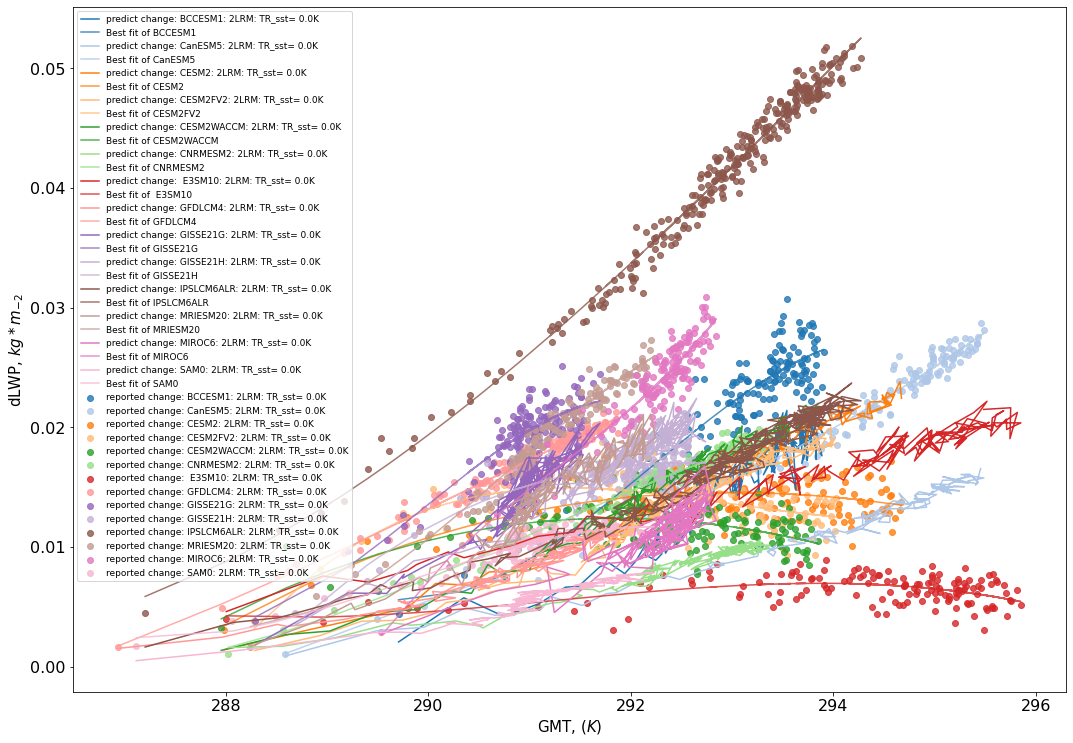

In [16]:
#.. abr Plot:

fig3, ax4  = plt.subplots(1, 1, figsize =(17.8, 12.6))   #(16.2, 9.3))
#ax3  = plt.axes()


# These are the colors that will be used in the plot
'''
ax4.set_prop_cycle(color=[
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])
'''
my_colors= array([
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])   #..plt.rcParams['axes.prop_cycle']()
my_colorst= my_colors

output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}

output_yrs = {}

for a in range(len(deck)):
    
    #if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   
    #..if deck_nas[a]!='BCCESM1':   #..BCCESM1
    #if deck_nas[a] =='BCCESM1':
    output_yrs[deck_nas[a]]  = arange(shape_yr_modelPI[deck_nas[a]]+shape_yr_modelabr[deck_nas[a]])

    output_dabrmeanpi_report[deck_nas[a]] = output_report[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_report[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
    output_dabrmeanpi_predict[deck_nas[a]] = output_predict[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_predict[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])

    ax4.scatter(output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]: shape_yr_modelPI[deck_nas[a]]+299], output_dabrmeanpi_report[deck_nas[a]][0:299], label='reported change: '+deck_nas[a]+ f': 2LRM: TR_sst= {Tr_sst}K', alpha =0.8, c= my_colors[a]) 
    ax4.plot(output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]: shape_yr_modelPI[deck_nas[a]]+299], output_dabrmeanpi_predict[deck_nas[a]][0:299], label='predict change: '+deck_nas[a]+ f': 2LRM: TR_sst= {Tr_sst}K', alpha = 1.0, c = my_colors[a])

    #plt.scatter(output_GMT[deck_nas[a]][0: 248], output_report[deck_nas[a]][0: 248], label='reported LWP: ' + deck_nas[a])
    #plt.plot(output_GMT[deck_nas[a]][0: 248], output_predict[deck_nas[a]][0: 248], label = 'predict LWP: ' + deck_nas[a])

    GMT = output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:shape_yr_modelPI[deck_nas[a]]+299]
    Yrs = output_yrs[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:shape_yr_modelPI[deck_nas[a]]+299]

    parameter = polyfit(GMT, output_dabrmeanpi_report[deck_nas[a]][0:299],3)
    #z1  = poly1d(parameter)
    #print(z1)
    y2 = parameter[0]*GMT**3 + parameter[1]*GMT**2 +parameter[2]*GMT + parameter[3]

    ax4.plot(GMT, y2, label='Best fit of '+ deck_nas[a], alpha=0.8, c = my_colors[a])
'''
for b in range(len(deck)):
    
    #if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   #..BCCESM1
    if deck_nas[b]!='BCCESM1':   #..BCCESM1
'''


plt.xlabel('GMT, '+ r'$(K)$', fontsize= 15)
plt.ylabel('dLWP, '+r'$kg*m_{-2}$', fontsize= 15)
#plt.title("Changes of LWP | abr4x - mean(pi-C) for GISSE21H and the ployfit", fontsize =19)

ax4.legend(loc='upper left', fontsize= 9)   #..loc='best', bbox_to_anchor=(-0.55, 0.38, 0.5, 0.63)

#..plt.savefig('CESM2 & variants_276K_ 2lrm')
#plt.savefig("Linear_Regression_multiple models_abrupt4x&pi-C_ 0K_ overgmt.png")
#plt.savefig('LWP changes from meanstate to abr_ 270K _ overgmt')

#plt.savefig('CanESM5_over gmt_ 2 lrm')
#..plt.savefig('Variabilities of liquid-cloud amount(LWP) in 11 GCM_ 2lrm_270K')

#plt.savefig("CESM2_2lrm_282K _overyrs")

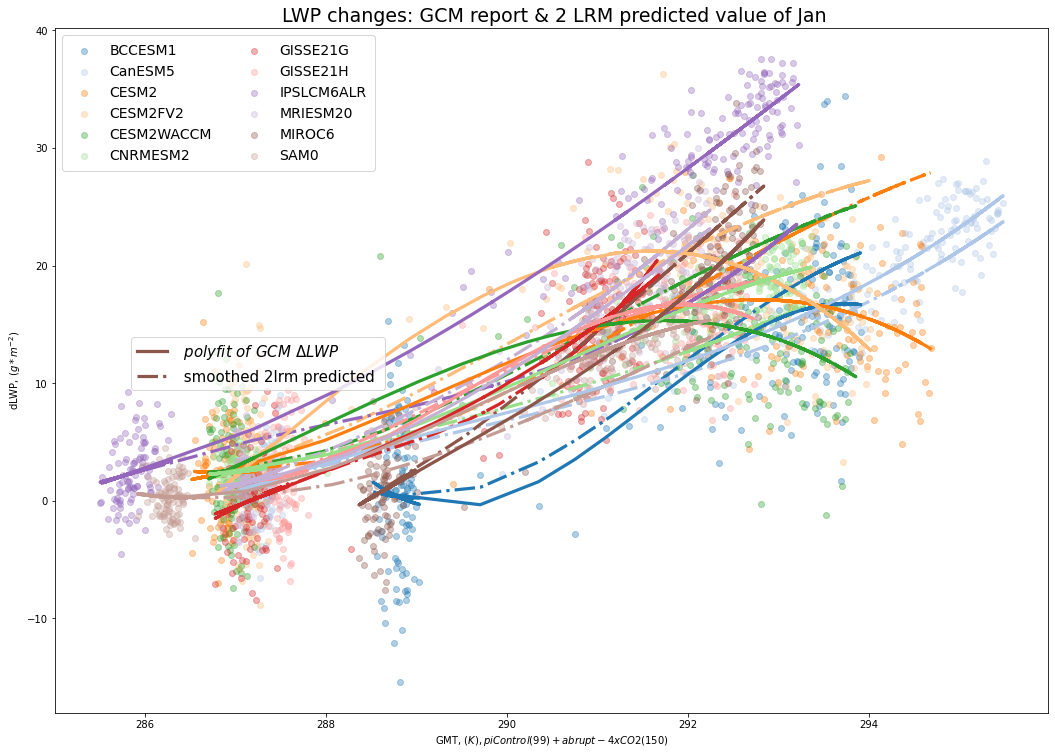

In [10]:
#...pi-C + Abr Plot:

fig5, ax5  = plt.subplots(1, 1, figsize =(17.8, 12.6))  #(16.2, 9.3))
#ax4  = plt.axes()
parameters = {'axes.labelsize': 22, 'legend.fontsize': 14,
          'axes.titlesize': 19, 'xtick.labelsize': 21, 'ytick.labelsize':21}
plt.rcParams.update(parameters)


# These are the colors that will be used in the plot
my_colors= array([
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])   #..plt.rcParams['axes.prop_cycle']()

my_colorst= my_colors
b = '2 LRM'

output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}
output_yrs = {}

# add a random value(s=1) to make line separate a little bit
at = random.rand(18) * 3.0
shape_yr_modelPI = 99
shape_yr_modelabr = 150
plot_lines1 = []
plot_lines2 = []

for a in range(len(deck2)):
    
    # plt.hold(True)
    
    # if deck_nas2[a]=='INM_CM48':   #..BCCESM1
    #if (deck_nas2[a] == 'E3SM10') or (deck_nas2[a]== 'BCCESM1') or (deck_nas2[a] =='GFDLCM4'): 
    ##..if deck_nas2[a]=='BCCESM1' or deck_nas2[a]=='CanESM5' or deck_nas2[a]=='GISSE21H' or deck_nas2[a]=='GISSE21G':
    
    output_yrs[deck_nas2[a]]  = arange(shape_yr_modelPI + shape_yr_modelabr)
    output_dabrmeanpi_report[deck_nas2[a]] = output_2lrm_report[deck_nas2[a]]['LWP'][0:shape_yr_modelPI+shape_yr_modelabr] - mean(output_2lrm_report[deck_nas2[a]]['LWP'][0:shape_yr_modelPI])
    output_dabrmeanpi_predict[deck_nas2[a]] = output_2lrm_predicted[deck_nas2[a]]['LWP'][0:shape_yr_modelPI+shape_yr_modelabr] - mean(output_2lrm_predicted[deck_nas2[a]]['LWP'][0:shape_yr_modelPI])


    ax5.scatter(output_GMT[deck_nas2[a]][0:249], 1000.*output_dabrmeanpi_report[deck_nas2[a]][0:249] +at[a], alpha = 0.35, c= my_colors[a], label = deck_nas2[a], zorder=0)   #.., label='report change'+deck_nas2[a]
    # l2, = ax5.plot(output_GMT[deck_nas2[a]][0:249], 1000*output_dabrmeanpi_predict[deck_nas2[a]][0:249], c = my_colors[a]) #.., label='predict change: '+deck_nas2[a]+ f': 2LRM: TR_sst= {Tr_sst}K' 
    # plot_lines2.append(l2)
    
    #plt.scatter(output_GMT[deck_nas2[a]][0: 248], output_report[deck_nas2[a]][0: 248], label='reported LWP: ' + deck_nas2[a])
    #plt.plot(output_GMT[deck_nas2[a]][0: 248], output_predict[deck_nas2[a]][0: 248], label = 'predict LWP: ' + deck_nas2[a])

    GMT = output_GMT[deck_nas2[a]][0:249]
    Yrs = output_yrs[deck_nas2[a]][0:249]
    
    parameter = polyfit(GMT[0:249], output_dabrmeanpi_report[deck_nas2[a]][0:249],3)
    #z1  = poly1d(parameter)
    #print(z1)
    y2 = parameter[0]*GMT**3 + parameter[1]*GMT**2 +parameter[2]*GMT + parameter[3]
    l1, = ax5.plot(GMT, 1000.* y2+at[a], alpha = 1, linewidth= 3.20,  c = my_colors[a], zorder =2) # , label='Best fit of '+ deck_nas2[a]
    plot_lines1.append(l1)
    
    parameter2 = polyfit(GMT[0:249], output_dabrmeanpi_predict[deck_nas2[a]][0:249], 3)
    y3 = parameter2[0]*GMT**3 + parameter2[1]*GMT**2 +parameter2[2]*GMT +parameter2[3]
    l2, = ax5.plot(GMT, 1000.* y3 +at[a], alpha = 1, linewidth = 3.20, linestyle='-.', c = my_colors[a], zorder= 1)
    plot_lines2.append(l2)

plt.xlabel('GMT, '+ r'$(K), piControl(99)+ abrupt-4xCO2(150)$' )
plt.ylabel('dLWP, '+r'$( g*m^{-2})$' )
plt.title(" LWP changes: GCM report & "+ b + " predicted value of Jan")
# plt.title(" Changes of LWP from mean-state(pi), SO annualy variabilities of 17 GCM: \n"+r'$piControl (99 yrs) + abrupt-4xCO2 (150 yrs),$'+ "GCM values v.s. 1-lrm regressed value")

legend1 = plt.legend([plot_lines1[-2], plot_lines2[-2]], [r'$\ polyfit\ of\ GCM\ \Delta LWP$', ' smoothed 2lrm predicted '], loc='upper right', bbox_to_anchor=(0.34, 0.56), fontsize = 15)  # bboxtoanchor(argu: x, y, width, height) 
plt.legend(loc='upper left', ncol =2, borderpad=0.6)  # 
plt.gca().add_artist(legend1)



#...best fit plot

# plt.savefig(path6+"plot_swradiation_Janlwpchange2lrm", dpi = 250)

# plt.savefig(path6+"plot1_GCMs_LWP_variability", dpi =500)
# plt.savefig(path6+"plot2_simgle_regime_LRM_performance", dpi=500)

/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/BCC-ESM1_best(test4)fit_283.38_dats.npz
75
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CanESM5_best(test4)fit_274.04_dats.npz
74
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CESM2_best(test4)fit_282.72_dats.npz
72
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CESM2-FV2_best(test4)fit_282.59_dats.npz
76
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CESM2-WACCM_best(test4)fit_282.83_dats.npz
78
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CNRM-ESM2-1_best(test4)fit_274.42_dats.npz
78
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/GISS-E2-1-G_best(test4)fit_281.97_dats.npz
78
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/GISS-E2-1-H_best(test4)fit_280.42_dats.npz
78
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/IPSL-CM6A-LR_best(test4)fit_275.83_dats.npz
79
f z
/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/MRI-ESM2-0_bes

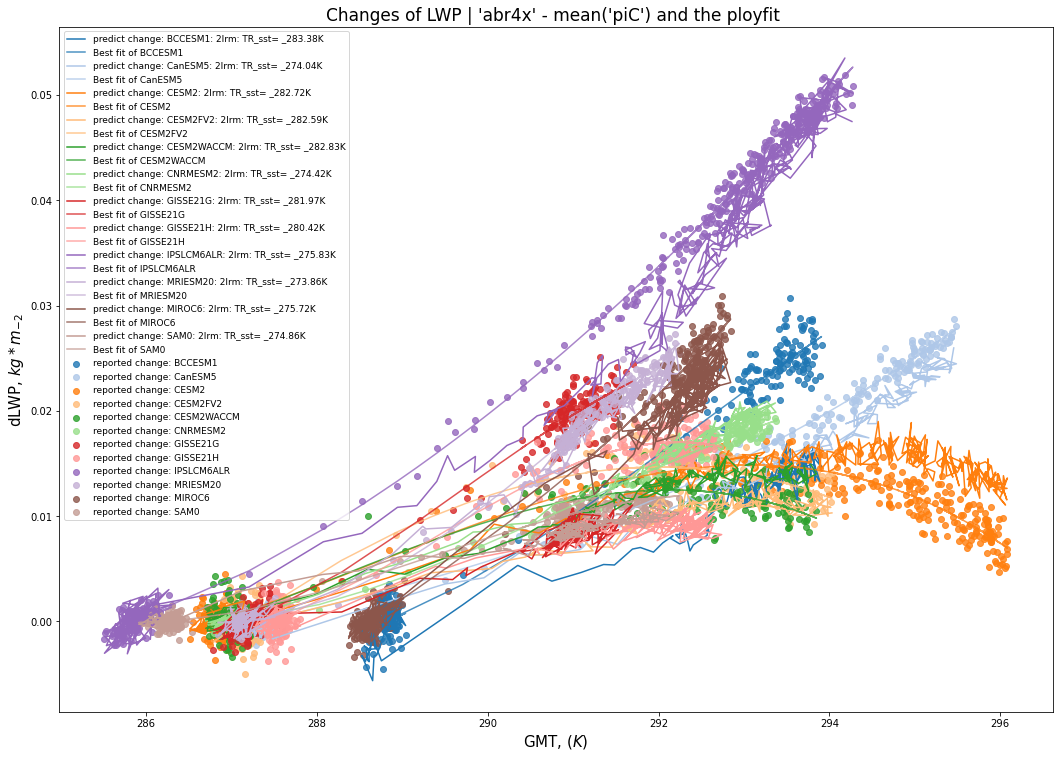

In [10]:
#...best fit plot:

fig5, ax5  = plt.subplots(1, 1, figsize =(17.8, 12.6))  #(16.2, 9.3))
#ax3  = plt.axes()


parameters = {'axes.labelsize': 22, 'legend.fontsize': 13,
          'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize':16}
plt.rcParams.update(parameters)


# These are the colors that will be used in the plot
my_colors= array([
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])   #..plt.rcParams['axes.prop_cycle']()
my_colorst= my_colors

output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}

output_yrs = {}

for a in range(len(deck2)):
    
    #if deck_nas2[a]=='CESM2'or deck_nas2[a]=='CESM2FV2' or deck_nas2[a]=='CESM2WACCM': 
    #..if deck_nas2[a]=='BCCESM1' or deck_nas2[a]=='CanESM5' or deck_nas2[a]=='GISSE21H' or deck_nas2[a]=='GISSE21G'

    folder =  glob.glob(path1+deck2[a]['modn']+'_best(test4)fit_'+'*' +'_dats.npz')
    if len(folder[1]) < len(folder[0]): 
        folder_2lrm =  folder[1]
    else:
        folder_2lrm =  folder[0]

    print(folder_2lrm)
    index_st_sst = folder_2lrm.index('fit')
    print(index_st_sst)
    index_ed_sst = folder_2lrm.index('z')
    print(list(folder_2lrm)[index_st_sst], list(folder_2lrm)[index_ed_sst])

    output_yrs[deck_nas2[a]]  = arange(shape_yr_modelPI[deck_nas2[a]] + shape_yr_modelabr[deck_nas2[a]])
    output_dabrmeanpi_report[deck_nas2[a]] = output_report[deck_nas2[a]][0:] - mean(output_report[deck_nas2[a]][0:shape_yr_modelPI[deck_nas2[a]]])
    output_dabrmeanpi_predict[deck_nas2[a]] = output_predict[deck_nas2[a]][0:] - mean(output_predict[deck_nas2[a]][0:shape_yr_modelPI[deck_nas2[a]]])


    ax5.scatter(output_GMT[deck_nas2[a]][0:], output_dabrmeanpi_report[deck_nas2[a]][0:], label='reported change: '+deck_nas2[a], alpha =0.8, c= my_colors[a])   #  +': 4lrm: TR_sst= 0.0K, TR_sub = 0.0'
    ax5.plot(output_GMT[deck_nas2[a]][0:], output_dabrmeanpi_predict[deck_nas2[a]][0:], label='predict change: '+deck_nas2[a]+": 2lrm: TR_sst= " +str(folder_2lrm)[index_st_sst+3:index_ed_sst-8]+ "K", alpha = 1.0, c = my_colors[a])

    GMT = output_GMT[deck_nas2[a]][0:]
    Yrs = output_yrs[deck_nas2[a]][0:]   #..+149

    parameter = polyfit(GMT[0: ], output_dabrmeanpi_report[deck_nas2[a]][0:],3)
    #z1  = poly1d(parameter)
    #print(z1)
    y2 = parameter[0]*GMT**3 + parameter[1]*GMT**2 +parameter[2]*GMT + parameter[3]

    ax5.plot(GMT, y2, label='Best fit of '+ deck_nas2[a], alpha = 0.8, c = my_colors[a])



plt.xlabel('GMT, '+ r'$(K)$', fontsize= 15)
plt.ylabel('dLWP, '+r'$kg*m_{-2}$', fontsize= 15)
plt.title("Changes of LWP | 'abr4x' - mean('piC') and the ployfit ",  fontsize =17)

plt.legend(loc='upper left', fontsize= 9)  #.loc='best', bbox_to_anchor=(-0.55, 0.38, 0.5, 0.63)

#...best fit plot
#..plt.savefig("badbehaviormodel_(bestfit3)_2lrm", dpi=500)
#plt.savefig('Variabilities of liquid-cloud-amount_pi+abr_2lrm_(best_test3)K', dpi =300)



(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)


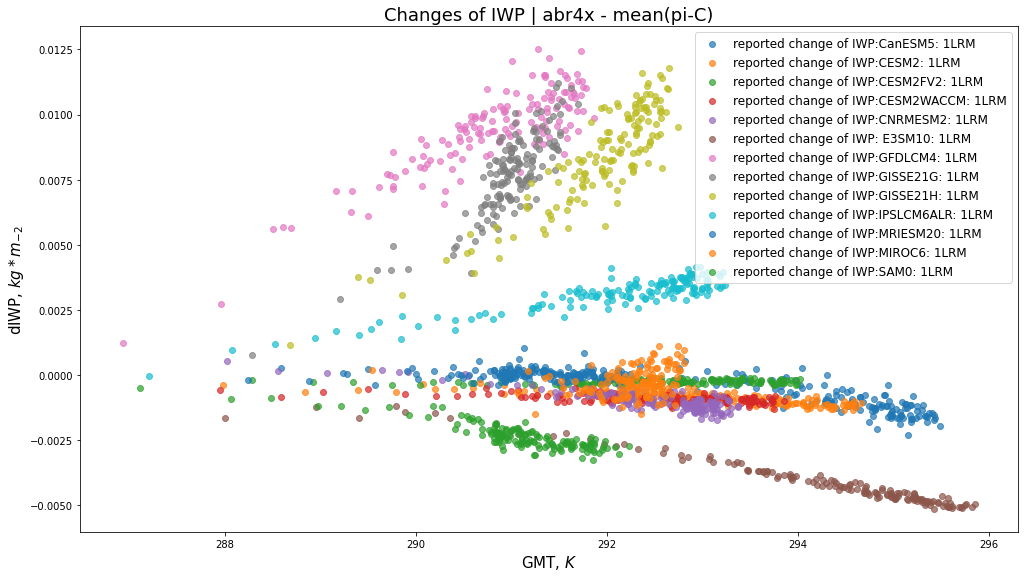

In [5]:
#.. abrupt+piC Plot for Ice Water Path:

fig3  = plt.figure(figsize = (16.8, 9.3))  #(16.2, 9.3))
ax3  = plt.axes()

output_yr_abr= {}
output_yr_PI = {}

output_IWP_PI = {}
output_IWP_abr = {}
#..set are-mean range and define functio
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10


output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}

for a in range(len(deck)):
    
    output_yr_PI[deck_nas[a]]  = output_dict0_PI[deck_nas[a]]['dict1_yr_bin_PI']
    output_yr_abr[deck_nas[a]]  = output_dict0_abr[deck_nas[a]]['dict1_yr_bin_abr']
    
    
    output_IWP_abr[deck_nas[a]] = area_mean(output_yr_abr[deck_nas[a]]['IWP_yr_bin'], y_range, x_range)
    output_IWP_PI[deck_nas[a]] = area_mean(output_yr_PI[deck_nas[a]]['IWP_yr_bin'], y_range, x_range)
    #print(output_IWP_PI[deck_nas[a]].shape)
    
    #if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   #.. BCCESM1
    if deck_nas[a]!='BCCESM1':
        
        output_dabrmeanpi_report[deck_nas[a]] = output_IWP_abr[deck_nas[a]][0:149] - mean(output_IWP_PI[deck_nas[a]])
        print(output_dabrmeanpi_report[deck_nas[a]].shape)
        
        plt.scatter(output_GMT[deck_nas[a]][99:248], output_dabrmeanpi_report[deck_nas[a]], label='reported change of IWP:'+deck_nas[a]+': 1LRM', alpha =0.7) 
        #plt.plot(output_GMT[deck_nas[a]][99:249], output_dabrmeanpi_predict[deck_nas[a]], label='predict change: '+deck_nas[a]+': 1LRM', alpha =1)
        
        #plt.scatter(output_GMT[deck_nas[a]][0: 248], output_report[deck_nas[a]][0: 248], label='reported LWP: ' + deck_nas[a])
        #plt.plot(output_GMT[deck_nas[a]][0: 248], output_predict[deck_nas[a]][0: 248], label = 'predict LWP: ' + deck_nas[a])
            
            
plt.xlabel('GMT, '+ r'$K$', fontsize= 15)
plt.ylabel('dIWP, '+r'$kg*m_{-2}$', fontsize= 15)
plt.title("Changes of IWP | abr4x - mean(pi-C)", fontsize =18)

plt.legend(loc='upper right',  fontsize= 12)

#plt.savefig("Linear_Regression_multiple models_abrupt4x&pi-C_ 0K_ overgmt.png")
#plt.savefig('LWP changes from meanstate to abr_ 0K_ overgmt')
#plt.savefig('CESM2 & variants')

#plt.savefig('Variabilities of liquid-cloud amount(LWP) in 11 GCM')
#plt.savefig('Variabilities of IWP in 11GCMs')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

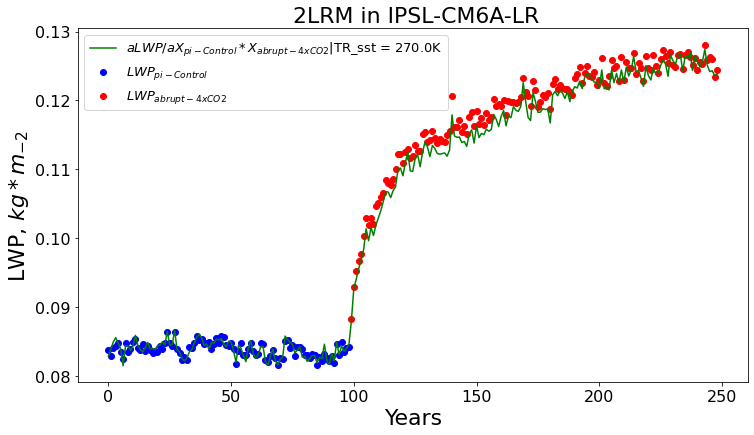

In [31]:
#..abrupt+piC Plot:

fig2  = plt.figure(figsize = (12, 6.5))
ax2  = plt.axes()
parameters = {'axes.labelsize': 22, 'legend.fontsize': 13,
          'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize':16}
plt.rcParams.update(parameters)

#deck  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]
xiu = arange(0, shape_yr_modelPI[deck_nas[8]]+150)
print(xiu)

output_yrs = {}
for b in range(len(deck_nas)):
    if deck_nas[b] == 'IPSLCM6ALR':
        
        output_yrs[deck_nas[b]] = arange(0, shape_yr_modelPI[deck_nas[b]]+150)
        print(output_yrs[deck_nas[b]].shape)
        plt.scatter(output_yrs[deck_nas[b]][:99], output_report[deck_nas[b]][:99], label='$LWP_{pi-Control} $', c='b')
        
        plt.scatter(output_yrs[deck_nas[b]][99:249], output_report[deck_nas[b]][99:249], label='$LWP_{abrupt-4xCO2} $', c= 'r')
        plt.plot(output_yrs[deck_nas[b]], output_predict[deck_nas[b]][:249], "g", label='$aLWP/aX_{pi-Control}*{X_{abrupt-4xCO2}}| $'+'TR_sst = 270.0K')
        


print(array(output_yrs).shape)

plt.xlabel('Years', fontsize=22)
        
plt.ylabel('LWP, '+r'$kg *m_{-2}$', fontsize=22)
plt.title(" 2LRM in IPSL-CM6A-LR", fontsize=22)  #..!!
plt.legend( )
#plt.ylim((0.105, 0.121))

#plt.savefig("Schematic_2LRM 270K_ IPSLCM6ALR")
